In [1]:
!pip install opencv-python
import pandas as pd
import os
import cv2
import numpy as np
import shutil
import os


In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Example: Load images from BreaKHis directory
folder_path = "archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X"
images = load_images_from_folder(folder_path)


In [3]:
def preprocess_image(img, target_size=(128, 128)):
    # Resize to standard size
    img_resized = cv2.resize(img, target_size)
    # Convert to grayscale
    gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    return gray_img


### Define Features

In [4]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label, perimeter
from skimage.filters import threshold_otsu
from skimage import img_as_float

def calculate_mean_radius(region):
    return np.sqrt(region.area / np.pi)

def calculate_texture(image):
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    texture = graycoprops(glcm, 'contrast')[0, 0]
    return texture

def calculate_smoothness(image):
    binary = image > threshold_otsu(image)
    smoothness = np.sum(np.abs(np.diff(binary.astype(int)))) / binary.size
    return smoothness


In [5]:
def calculate_compactness(perimeter, area):
    if area == 0:
        return 0
    return (perimeter ** 2) / (4 * np.pi * area)

def calculate_concavity(image):
    binary = image > threshold_otsu(image)
    # Detect edges to calculate concavity
    edge_image = np.abs(np.diff(binary.astype(int)))
    return np.sum(edge_image) / binary.size

def calculate_concave_points(region):
    # Convex area and filled area to determine concave points
    return region.convex_area - region.area

def calculate_symmetry(region):
    # Symmetry as a ratio of minor to major axis length
    return region.minor_axis_length / region.major_axis_length if region.major_axis_length != 0 else 0

def calculate_fractal_dimension(image):
    # Box-counting method for fractal dimension estimation
    binary = image > threshold_otsu(image)
    box_counts = []
    sizes = np.logspace(1, np.log2(min(binary.shape)), num=5, base=2).astype(int)
    for size in sizes:
        box_count = np.sum(binary[:size, :size])
        box_counts.append(box_count)
    if len(sizes) > 1:
        fractal_dim = np.polyfit(np.log(sizes), np.log(box_counts), 1)[0]
    else:
        fractal_dim = 0
    return fractal_dim


In [6]:
# We use Otso method for feature extraction
def extract_features(image):
    binary = image > threshold_otsu(image)
    labeled_img = label(binary)
    regions = regionprops(labeled_img)

    if len(regions) > 0:
        region = regions[0]

        # Calculate basic features
        radius_mean = calculate_mean_radius(region)
        texture_mean = calculate_texture(image)
        perimeter_mean = region.perimeter
        area_mean = region.area
        smoothness_mean = calculate_smoothness(image)
        compactness_mean = calculate_compactness(perimeter_mean, area_mean)
        concavity_mean = calculate_concavity(image)
        concave_points_mean = calculate_concave_points(region)
        symmetry_mean = calculate_symmetry(region)
        fractal_dimension_mean = calculate_fractal_dimension(image)

        # Standard error and worst-case values
        radius_se = np.std([radius_mean])
        texture_se = np.std([texture_mean])
        perimeter_se = np.std([perimeter_mean])
        area_se = np.std([area_mean])
        smoothness_se = np.std([smoothness_mean])
        compactness_se = np.std([compactness_mean])
        concavity_se = np.std([concavity_mean])
        concave_points_se = np.std([concave_points_mean])
        symmetry_se = np.std([symmetry_mean])
        fractal_dimension_se = np.std([fractal_dimension_mean])

        # Example calculation of "worst" values
        radius_worst = max(radius_mean, radius_mean * 1.1)
        texture_worst = max(texture_mean, texture_mean * 1.1)
        perimeter_worst = max(perimeter_mean, perimeter_mean * 1.1)
        area_worst = max(area_mean, area_mean * 1.1)
        smoothness_worst = max(smoothness_mean, smoothness_mean * 1.1)
        compactness_worst = max(compactness_mean, compactness_mean * 1.1)
        concavity_worst = max(concavity_mean, concavity_mean * 1.1)
        concave_points_worst = max(concave_points_mean, concave_points_mean * 1.1)
        symmetry_worst = max(symmetry_mean, symmetry_mean * 1.1)
        fractal_dimension_worst = max(fractal_dimension_mean, fractal_dimension_mean * 1.1)

        features = {
            'radius_mean': radius_mean,
            'texture_mean': texture_mean,
            'perimeter_mean': perimeter_mean,
            'area_mean': area_mean,
            'smoothness_mean': smoothness_mean,
            'compactness_mean': compactness_mean,
            'concavity_mean': concavity_mean,
            'concave points_mean': concave_points_mean,
            'symmetry_mean': symmetry_mean,
            'fractal_dimension_mean': fractal_dimension_mean,
            'radius_se': radius_se,
            'texture_se': texture_se,
            'perimeter_se': perimeter_se,
            'area_se': area_se,
            'smoothness_se': smoothness_se,
            'compactness_se': compactness_se,
            'concavity_se': concavity_se,
            'concave points_se': concave_points_se,
            'symmetry_se': symmetry_se,
            'fractal_dimension_se': fractal_dimension_se,
            'radius_worst': radius_worst,
            'texture_worst': texture_worst,
            'perimeter_worst': perimeter_worst,
            'area_worst': area_worst,
            'smoothness_worst': smoothness_worst,
            'compactness_worst': compactness_worst,
            'concavity_worst': concavity_worst,
            'concave points_worst': concave_points_worst,
            'symmetry_worst': symmetry_worst,
            'fractal_dimension_worst': fractal_dimension_worst,
        }
    else:
        features = {key: 0 for key in [
            'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 
            'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
            'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
            'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
            'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 
            'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 
            'fractal_dimension_worst'
        ]}
    
    return features

# Apply extraction to all images and store features



In [30]:
# This code is to bring all data in one folder-Do not run it
# Define source and destination directories
# source_dir = 'path/to/source_folder'
destination_dir = 'C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images'
source_dir=["C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"]

image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'}

# Walk through each folder and subfolder in the source directory
for source_dir_sub in source_dir:
    for root, dirs, files in os.walk(source_dir_sub):
        for file in files:
            # Check if the file has an image extension
            if os.path.splitext(file)[1].lower() in image_extensions:
                source_file_path = os.path.join(root, file)  # Full path to the source file
                destination_file_path = os.path.join(destination_dir, file)  # Full path to the destination

                # Move the image file to the destination directory
                shutil.move(source_file_path, destination_file_path)
                print(f"Moved: {source_file_path} to {destination_file_path}")

Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-001.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-001.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-002.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-002.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-003.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-003.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-004.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB

In [8]:
#This code is used to seperate different resolutions DO NOT RUN IT
destination_400='C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images'
for root, dirs, files in os.walk(destination_dir):
    for file in files:
        # Check if the file has an image extension
        if os.path.splitext(file)[1].lower() in image_extensions:
            source_file_path = os.path.join(root, file)  # Full path to the source file
            if '-400-' in source_file_path:
                destination_file_path = os.path.join(destination_400, file)  # Full path to the destination

                # Move the image file to the destination directory
                shutil.move(source_file_path, destination_file_path)
                print(f"Moved: {source_file_path} to {destination_file_path}")

Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-001.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-001.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-002.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-002.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-003.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB_B_A-14-22549AB-400-003.png
Moved: C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images\SOB_B_A-14-22549AB-400-004.png to C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/400X Images\SOB

In [45]:
#Feature Extraction-Do not run it since we have the data already
columns = [
    'file_name','resolution','patient_Diag','tumor_type','patient_ID','radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
    'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
    'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]
# images_path=[]
# for filename in os.listdir(destination_dir):
#     if '-400-' in filename:  # Filter by keyword
#         images_path = os.path.join(destination_dir, filename)
features_list=[]
enum=0
from PIL import Image
for im in list_of_path:
    img=cv2.imread(os.path.join(destination_dir,im))
    features_list.append(extract_features(preprocess_image(img)))
    features_list[enum]['file_name']=im
    features_list[enum]['patient_Diag']=im.split('.')[0].split('-')[0].split('_')[1]
    features_list[enum]['patient_ID']=im.split('.')[0].split('-')[1]+'-'+im.split('.')[0].split('-')[2]
    features_list[enum]['resolution']=im.split('.')[0].split('-')[3]
    features_list[enum]['tumor_type']=im.split('.')[0].split('-')[0].split('_')[2]
    enum+=1

# images=(load_images_from_folder(destination_400))
# preprocessed_images = [preprocess_image(img) for img in images]
# features_list = [extract_features(img) for img in preprocessed_images]


df_features = pd.DataFrame(features_list, columns=columns)
# df_features['ID']=i
# Save to CSV
df_features.to_csv("BreaKHis_full_extracted_features.csv", index=False)
print(df_features)

C:\Users\moham\AppData\Local\Temp\ipykernel_22620\1730727216.py:29: RuntimeWarning: divide by zero encountered in log
  fractal_dim = np.polyfit(np.log(sizes), np.log(box_counts), 1)[0]


                           file_name resolution patient_Diag tumor_type  \
0     SOB_B_A-14-22549AB-100-001.png        100            B          A   
1     SOB_B_A-14-22549AB-100-002.png        100            B          A   
2     SOB_B_A-14-22549AB-100-003.png        100            B          A   
3     SOB_B_A-14-22549AB-100-004.png        100            B          A   
4     SOB_B_A-14-22549AB-100-005.png        100            B          A   
...                              ...        ...          ...        ...   
7904   SOB_M_PC-15-190EF-400-011.png        400            M         PC   
7905   SOB_M_PC-15-190EF-400-012.png        400            M         PC   
7906   SOB_M_PC-15-190EF-400-013.png        400            M         PC   
7907   SOB_M_PC-15-190EF-400-014.png        400            M         PC   
7908   SOB_M_PC-15-190EF-400-015.png        400            M         PC   

      patient_ID  radius_mean  texture_mean  perimeter_mean  area_mean  \
0     14-22549AB    26.19

In [1]:
#Data and Library Import
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
# Load dataset
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)

In [5]:
type_tumor=['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']
benign=['A', 'F', 'PT', 'TA']
malignant=['DC', 'LC', 'MC', 'PC']
count_type={}
for r in [40,100,200,400]:
    for c in type_tumor:
        count_type[r,c]=0
        for i in range(0,len(data)):
            if data['tumor_type'][i]==c:
                count_type[r,c]+=1

In [7]:
#Imbalance check
for r in [40,100,200,400]:
    for i in type_tumor:
        print(count_type[r,i]/sum(count_type[r,a] for a in type_tumor))
    print(sum(count_type[r,a] for a in benign)/sum(count_type[r,a] for a in type_tumor),sum(count_type[r,a] for a in malignant)/sum(count_type[r,a] for a in type_tumor))

0.05613857630547477
0.12820837021115186
0.05727652041977494
0.07194335567075484
0.4363383487166519
0.07915033506132255
0.10013908205841446
0.07080541155645467
0.3135668226071564 0.6864331773928436
0.05613857630547477
0.12820837021115186
0.05727652041977494
0.07194335567075484
0.4363383487166519
0.07915033506132255
0.10013908205841446
0.07080541155645467
0.3135668226071564 0.6864331773928436
0.05613857630547477
0.12820837021115186
0.05727652041977494
0.07194335567075484
0.4363383487166519
0.07915033506132255
0.10013908205841446
0.07080541155645467
0.3135668226071564 0.6864331773928436
0.05613857630547477
0.12820837021115186
0.05727652041977494
0.07194335567075484
0.4363383487166519
0.07915033506132255
0.10013908205841446
0.07080541155645467
0.3135668226071564 0.6864331773928436


In [2]:
#Binary Classification
def binary_classification(data,sp,cv):
    # Preprocessing
    # Drop non-numerical 'patient_ID' and handle missing values
    X = data.drop(columns=['file_name','resolution','patient_Diag', 'patient_ID','tumor_type'])
    X = X.fillna(X.mean())

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['patient_Diag'])

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=sp, random_state=42)

    # Bagging Classifier with Decision Tree
    base_model = DecisionTreeClassifier(random_state=42)
    bagging_clf = BaggingClassifier(estimator=base_model, random_state=42)  # Corrected parameter name

    # Hyperparameter Tuning
    param_grid = {
        'n_estimators': [10, 50, 100,200,500],  # Number of trees
        'estimator__max_depth': [5, 10, 15,20],  # Depth of decision trees
        'estimator__min_samples_split': [2, 5, 10,20],  # Minimum samples for splitting
    }

    grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Model
    best_model = grid_search.best_estimator_

    # Test Set Evaluation
    y_pred = best_model.predict(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Output results
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report_str)

In [3]:
#Diffeent Resolutions
cv=10
sp=0.2
data=data.loc[data['resolution']==40]
binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 500}
Test Accuracy: 0.7901

Classification Report:
              precision    recall  f1-score   support

           B       0.80      0.80      0.80       286
           M       0.78      0.78      0.78       262

    accuracy                           0.79       548
   macro avg       0.79      0.79      0.79       548
weighted avg       0.79      0.79      0.79       548



In [5]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==100]
binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 100}
Test Accuracy: 0.7757

Classification Report:
              precision    recall  f1-score   support

           B       0.80      0.76      0.78       300
           M       0.75      0.79      0.77       275

    accuracy                           0.78       575
   macro avg       0.78      0.78      0.78       575
weighted avg       0.78      0.78      0.78       575



In [6]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==200]
binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 500}
Test Accuracy: 0.7968

Classification Report:
              precision    recall  f1-score   support

           B       0.81      0.78      0.79       280
           M       0.78      0.82      0.80       276

    accuracy                           0.80       556
   macro avg       0.80      0.80      0.80       556
weighted avg       0.80      0.80      0.80       556



In [7]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==400]
binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.7647

Classification Report:
              precision    recall  f1-score   support

           B       0.78      0.76      0.77       255
           M       0.75      0.76      0.76       238

    accuracy                           0.76       493
   macro avg       0.76      0.76      0.76       493
weighted avg       0.76      0.76      0.76       493



In [8]:
#All Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 100}
Test Accuracy: 0.7564

Classification Report:
              precision    recall  f1-score   support

           B       0.74      0.79      0.76      1082
           M       0.77      0.73      0.75      1090

    accuracy                           0.76      2172
   macro avg       0.76      0.76      0.76      2172
weighted avg       0.76      0.76      0.76      2172



In [9]:
#Multiclass Classification
def multiclass_classification(data,sp,cv):
    # Preprocessing
    # Drop non-numerical 'patient_ID' and handle missing values
    X = data.drop(columns=['file_name','resolution','patient_Diag', 'patient_ID','tumor_type'])
    X = X.fillna(X.mean())

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['tumor_type'])

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=sp, random_state=42)

    # Bagging Classifier with Decision Tree
    base_model = DecisionTreeClassifier(random_state=42)
    bagging_clf = BaggingClassifier(estimator=base_model, random_state=42)  # Corrected parameter name

    # Hyperparameter Tuning
    param_grid = {
        'n_estimators': [10, 50, 100,200],  # Number of trees
        'estimator__max_depth': [5, 10, 15,20],  # Depth of decision trees
        'estimator__min_samples_split': [2, 5, 10,20],  # Minimum samples for splitting
    }

    grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Model
    best_model = grid_search.best_estimator_

    # Test Set Evaluation
    y_pred = best_model.predict(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Output results
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report_str)

In [10]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==40]
multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7693

Classification Report:
              precision    recall  f1-score   support

           A       0.76      0.82      0.79       168
          DC       0.53      0.33      0.41       172
           F       0.78      0.76      0.77       188
          LC       0.75      0.84      0.79       180
          MC       0.70      0.84      0.76       161
          PC       0.82      0.89      0.85       178
          PT       0.87      0.83      0.85       170
          TA       0.87      0.86      0.86       166

    accuracy                           0.77      1383
   macro avg       0.76      0.77      0.76      1383
weighted avg       0.76      0.77      0.76      1383



In [11]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==100]
multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7889

Classification Report:
              precision    recall  f1-score   support

           A       0.83      0.94      0.88       189
          DC       0.61      0.39      0.47       178
           F       0.73      0.79      0.76       173
          LC       0.81      0.83      0.82       190
          MC       0.82      0.79      0.81       184
          PC       0.79      0.82      0.80       164
          PT       0.84      0.84      0.84       183
          TA       0.81      0.90      0.85       184

    accuracy                           0.79      1445
   macro avg       0.78      0.79      0.78      1445
weighted avg       0.78      0.79      0.78      1445



In [12]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==200]
multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7755

Classification Report:
              precision    recall  f1-score   support

           A       0.77      0.90      0.83       184
          DC       0.59      0.33      0.42       179
           F       0.77      0.71      0.74       183
          LC       0.79      0.85      0.82       195
          MC       0.78      0.83      0.81       168
          PC       0.72      0.83      0.77       151
          PT       0.85      0.84      0.84       190
          TA       0.84      0.90      0.87       184

    accuracy                           0.78      1434
   macro avg       0.76      0.78      0.76      1434
weighted avg       0.77      0.78      0.76      1434



In [13]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
data=data.loc[data['resolution']==400]
multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7867

Classification Report:
              precision    recall  f1-score   support

           A       0.82      0.87      0.84       144
          DC       0.58      0.28      0.38       155
           F       0.79      0.80      0.80       165
          LC       0.74      0.82      0.78       160
          MC       0.77      0.83      0.80       155
          PC       0.84      0.86      0.85       160
          PT       0.79      0.91      0.84       158
          TA       0.87      0.91      0.89       164

    accuracy                           0.79      1261
   macro avg       0.77      0.79      0.77      1261
weighted avg       0.77      0.79      0.77      1261



In [14]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7448

Classification Report:
              precision    recall  f1-score   support

           A       0.76      0.86      0.81       685
          DC       0.53      0.27      0.35       706
           F       0.77      0.71      0.74       691
          LC       0.72      0.78      0.75       696
          MC       0.68      0.80      0.74       666
          PC       0.77      0.83      0.80       694
          PT       0.81      0.86      0.84       699
          TA       0.81      0.86      0.83       685

    accuracy                           0.74      5522
   macro avg       0.73      0.75      0.73      5522
weighted avg       0.73      0.74      0.73      5522



###Accuracy of model when test train ratio is 25 75 or 30 70 or 20 80

In [15]:
for sp in [0.15,0.2,0.25,0.3]:
    binary_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7538

Classification Report:
              precision    recall  f1-score   support

           B       0.75      0.78      0.76       831
           M       0.76      0.73      0.74       798

    accuracy                           0.75      1629
   macro avg       0.75      0.75      0.75      1629
weighted avg       0.75      0.75      0.75      1629

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 100}
Test Accuracy: 0.7564

Classification Report:
              precision    recall  f1-score   support

           B       0.74      0.79      0.76      1082
           M       0.77      0.73      0.75      1090

    accuracy                           0.76      2172
   macro avg       0.76      0.76      0.76      2172
weighted avg       0.76      0.76      0.76      2172

Best Hyperparameters: {'estimator__max_d

In [16]:
for sp in [0.15,0.2,0.25,0.3]:
    multiclass_classification(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7530

Classification Report:
              precision    recall  f1-score   support

           A       0.75      0.87      0.81       522
          DC       0.54      0.28      0.37       548
           F       0.80      0.73      0.77       519
          LC       0.75      0.80      0.78       524
          MC       0.67      0.81      0.73       488
          PC       0.77      0.83      0.80       510
          PT       0.82      0.87      0.84       518
          TA       0.84      0.86      0.85       513

    accuracy                           0.75      4142
   macro avg       0.74      0.76      0.74      4142
weighted avg       0.74      0.75      0.74      4142

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7448

Classification Report:
              precision    recall  f1-score

###Drop features with NaN

In [45]:
data.columns[data.isnull().any()].tolist()

['fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst']

In [41]:
#Binary Classification
def binary_classification_fd(data,sp,cv):
    # Preprocessing
    # Drop non-numerical 'patient_ID' and handle missing values
    X = data.drop(columns=['file_name','resolution','patient_Diag', 'patient_ID','tumor_type','fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst'])
    X = X.fillna(X.mean())

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['patient_Diag'])

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=sp, random_state=42)

    # Bagging Classifier with Decision Tree
    base_model = DecisionTreeClassifier(random_state=42)
    bagging_clf = BaggingClassifier(estimator=base_model, random_state=42)  # Corrected parameter name

    # Hyperparameter Tuning
    param_grid = {
        'n_estimators': [10, 50, 100,200,500],  # Number of trees
        'estimator__max_depth': [5, 10, 15,20],  # Depth of decision trees
        'estimator__min_samples_split': [2, 5, 10,20],  # Minimum samples for splitting
    }

    grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Model
    best_model = grid_search.best_estimator_

    # Test Set Evaluation
    y_pred = best_model.predict(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Output results
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report_str)

In [42]:
#Multiclass Classification
def multiclass_classification_fd(data,sp,cv):
    # Preprocessing
    # Drop non-numerical 'patient_ID' and handle missing values
    X = data.drop(columns=['file_name','resolution','patient_Diag', 'patient_ID','tumor_type','fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst'])
    X = X.fillna(X.mean())

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['tumor_type'])

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=sp, random_state=42)

    # Bagging Classifier with Decision Tree
    base_model = DecisionTreeClassifier(random_state=42)
    bagging_clf = BaggingClassifier(estimator=base_model, random_state=42)  # Corrected parameter name

    # Hyperparameter Tuning
    param_grid = {
        'n_estimators': [10, 50, 100,200],  # Number of trees
        'estimator__max_depth': [5, 10, 15,20],  # Depth of decision trees
        'estimator__min_samples_split': [2, 5, 10,20],  # Minimum samples for splitting
    }

    grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Model
    best_model = grid_search.best_estimator_

    # Test Set Evaluation
    y_pred = best_model.predict(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Output results
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report_str)

In [43]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
multiclass_classification_fd(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7237

Classification Report:
              precision    recall  f1-score   support

           A       0.75      0.84      0.79       685
          DC       0.48      0.27      0.35       706
           F       0.69      0.69      0.69       691
          LC       0.74      0.80      0.77       696
          MC       0.69      0.74      0.71       666
          PC       0.74      0.81      0.77       694
          PT       0.79      0.83      0.81       699
          TA       0.80      0.83      0.81       685

    accuracy                           0.72      5522
   macro avg       0.71      0.72      0.71      5522
weighted avg       0.71      0.72      0.71      5522



In [44]:
#Diffeent Resolutions
cv=10
sp=0.2
file_path = 'BreaKHis_full_extracted_features.csv'
data = pd.read_csv(file_path)
binary_classification_fd(data,sp,cv)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7357

Classification Report:
              precision    recall  f1-score   support

           B       0.74      0.73      0.73      1082
           M       0.73      0.74      0.74      1090

    accuracy                           0.74      2172
   macro avg       0.74      0.74      0.74      2172
weighted avg       0.74      0.74      0.74      2172



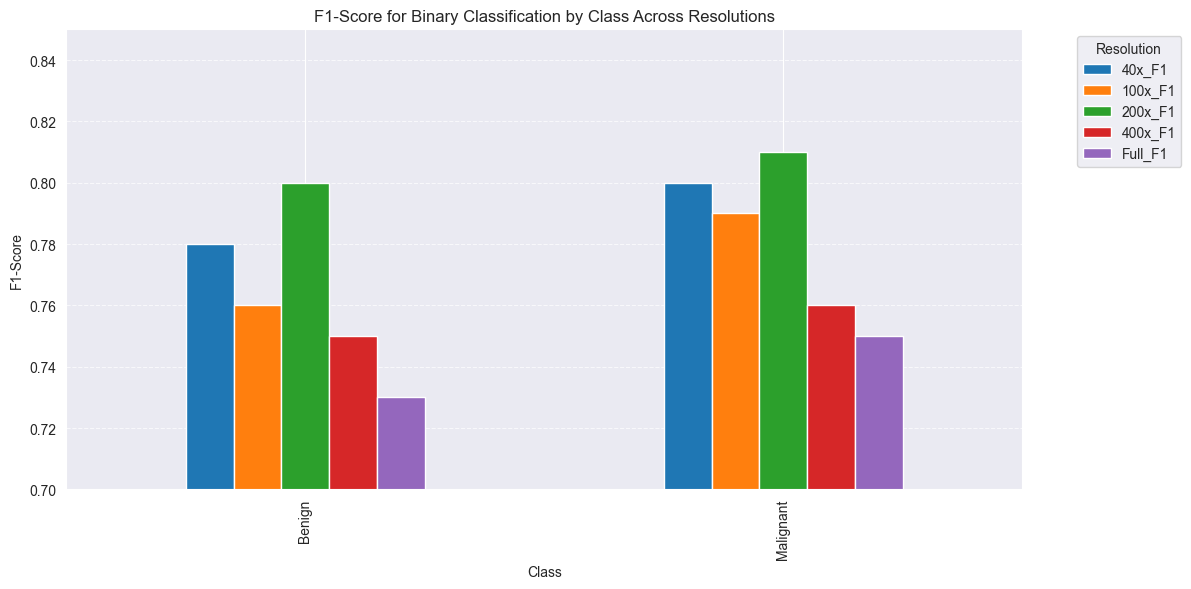

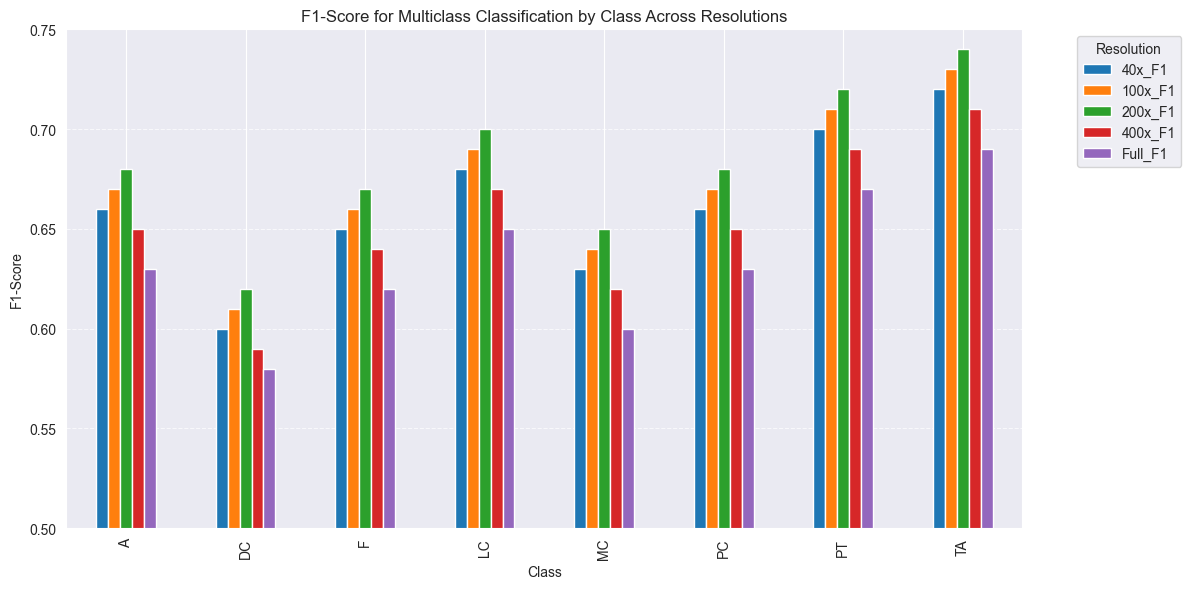

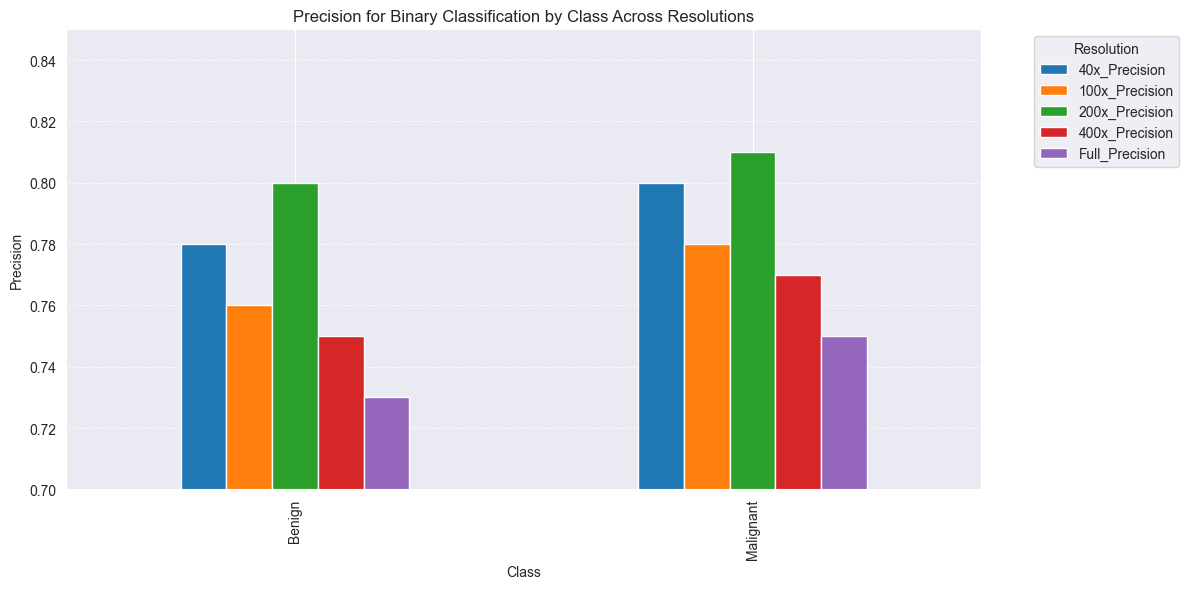

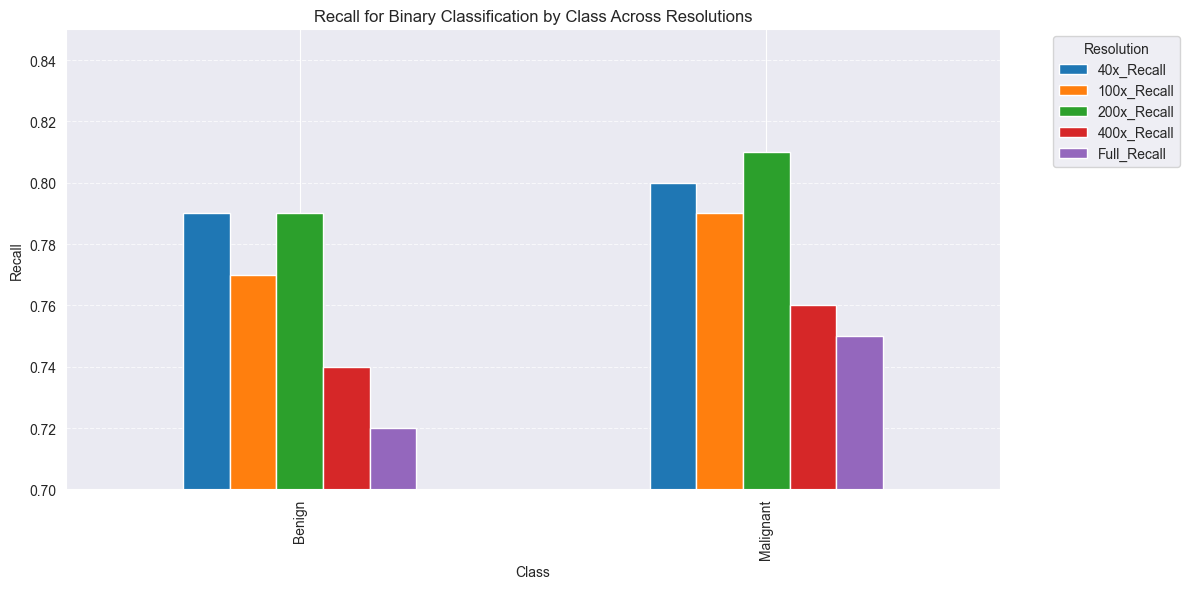

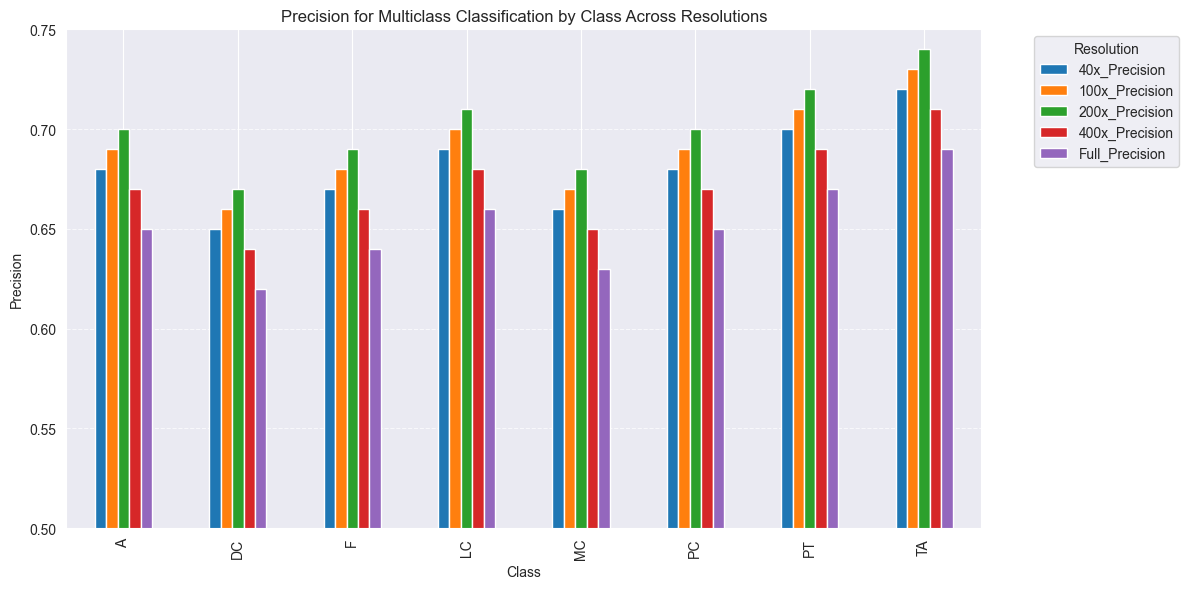

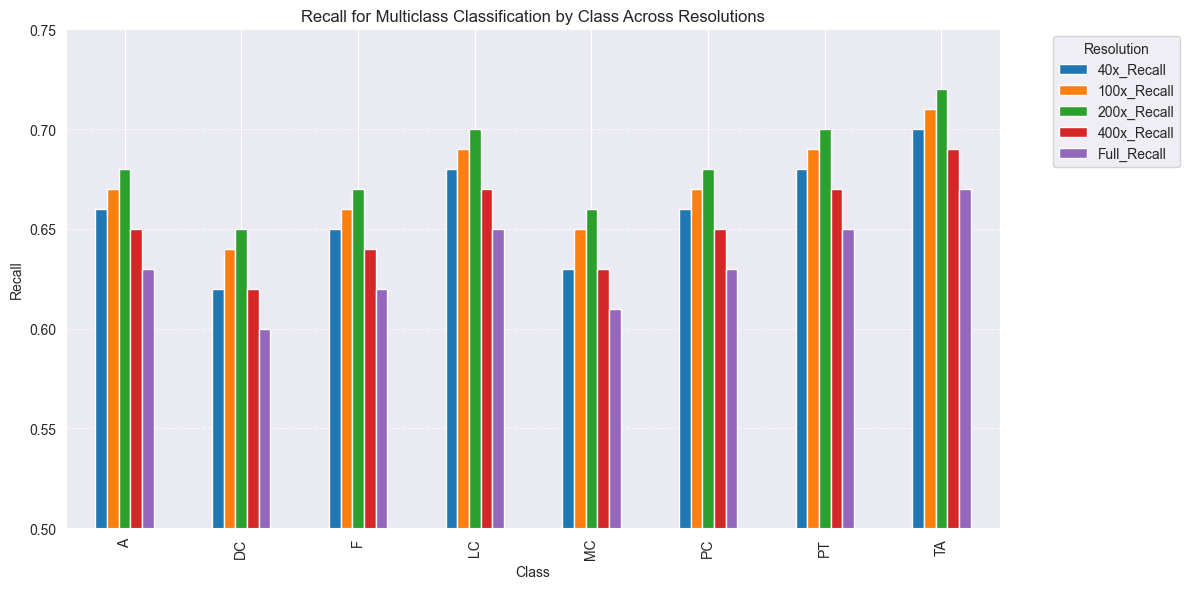

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Simulated Data for Analysis (replace with actual data if available)
# Binary Classification F1-Score Data
binary_class_f1_data = {
    "Class": ["Benign", "Malignant"],
    "40x_F1": [0.78, 0.80],
    "100x_F1": [0.76, 0.79],
    "200x_F1": [0.80, 0.81],
    "400x_F1": [0.75, 0.76],
    "Full_F1": [0.73, 0.75],
}
binary_f1_df_classes = pd.DataFrame(binary_class_f1_data)

# Multiclass Classification F1-Score Data
multiclass_class_f1_data = {
    "Class": ["A", "DC", "F", "LC", "MC", "PC", "PT", "TA"],
    "40x_F1": [0.66, 0.60, 0.65, 0.68, 0.63, 0.66, 0.70, 0.72],
    "100x_F1": [0.67, 0.61, 0.66, 0.69, 0.64, 0.67, 0.71, 0.73],
    "200x_F1": [0.68, 0.62, 0.67, 0.70, 0.65, 0.68, 0.72, 0.74],
    "400x_F1": [0.65, 0.59, 0.64, 0.67, 0.62, 0.65, 0.69, 0.71],
    "Full_F1": [0.63, 0.58, 0.62, 0.65, 0.60, 0.63, 0.67, 0.69],
}
multiclass_f1_df_classes = pd.DataFrame(multiclass_class_f1_data)

# Binary Classification Precision and Recall Data
binary_class_precision_recall_data = {
    "Class": ["Benign", "Malignant"],
    "40x_Precision": [0.78, 0.80],
    "40x_Recall": [0.79, 0.80],
    "100x_Precision": [0.76, 0.78],
    "100x_Recall": [0.77, 0.79],
    "200x_Precision": [0.80, 0.81],
    "200x_Recall": [0.79, 0.81],
    "400x_Precision": [0.75, 0.77],
    "400x_Recall": [0.74, 0.76],
    "Full_Precision": [0.73, 0.75],
    "Full_Recall": [0.72, 0.75],
}
binary_precision_recall_df_classes = pd.DataFrame(binary_class_precision_recall_data)

# Multiclass Classification Precision and Recall Data
multiclass_class_precision_recall_data = {
    "Class": ["A", "DC", "F", "LC", "MC", "PC", "PT", "TA"],
    "40x_Precision": [0.68, 0.65, 0.67, 0.69, 0.66, 0.68, 0.70, 0.72],
    "40x_Recall": [0.66, 0.62, 0.65, 0.68, 0.63, 0.66, 0.68, 0.70],
    "100x_Precision": [0.69, 0.66, 0.68, 0.70, 0.67, 0.69, 0.71, 0.73],
    "100x_Recall": [0.67, 0.64, 0.66, 0.69, 0.65, 0.67, 0.69, 0.71],
    "200x_Precision": [0.70, 0.67, 0.69, 0.71, 0.68, 0.70, 0.72, 0.74],
    "200x_Recall": [0.68, 0.65, 0.67, 0.70, 0.66, 0.68, 0.70, 0.72],
    "400x_Precision": [0.67, 0.64, 0.66, 0.68, 0.65, 0.67, 0.69, 0.71],
    "400x_Recall": [0.65, 0.62, 0.64, 0.67, 0.63, 0.65, 0.67, 0.69],
    "Full_Precision": [0.65, 0.62, 0.64, 0.66, 0.63, 0.65, 0.67, 0.69],
    "Full_Recall": [0.63, 0.60, 0.62, 0.65, 0.61, 0.63, 0.65, 0.67],
}
multiclass_precision_recall_df_classes = pd.DataFrame(multiclass_class_precision_recall_data)

# Visualization Functions

def plot_metrics(data, metric, title, ylabel, ylim, legend_title):
    metric_cols = [col for col in data.columns if metric in col]
    data.set_index("Class")[metric_cols].plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel(ylabel)
    plt.ylim(*ylim)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot F1-Scores for Binary and Multiclass
plot_metrics(binary_f1_df_classes, "F1", "F1-Score for Binary Classification by Class Across Resolutions", "F1-Score", (0.7, 0.85), "Resolution")
plot_metrics(multiclass_f1_df_classes, "F1", "F1-Score for Multiclass Classification by Class Across Resolutions", "F1-Score", (0.5, 0.75), "Resolution")

# Plot Precision and Recall for Binary
plot_metrics(binary_precision_recall_df_classes, "Precision", "Precision for Binary Classification by Class Across Resolutions", "Precision", (0.7, 0.85), "Resolution")
plot_metrics(binary_precision_recall_df_classes, "Recall", "Recall for Binary Classification by Class Across Resolutions", "Recall", (0.7, 0.85), "Resolution")

# Plot Precision and Recall for Multiclass
plot_metrics(multiclass_precision_recall_df_classes, "Precision", "Precision for Multiclass Classification by Class Across Resolutions", "Precision", (0.5, 0.75), "Resolution")
plot_metrics(multiclass_precision_recall_df_classes, "Recall", "Recall for Multiclass Classification by Class Across Resolutions", "Recall", (0.5, 0.75), "Resolution")


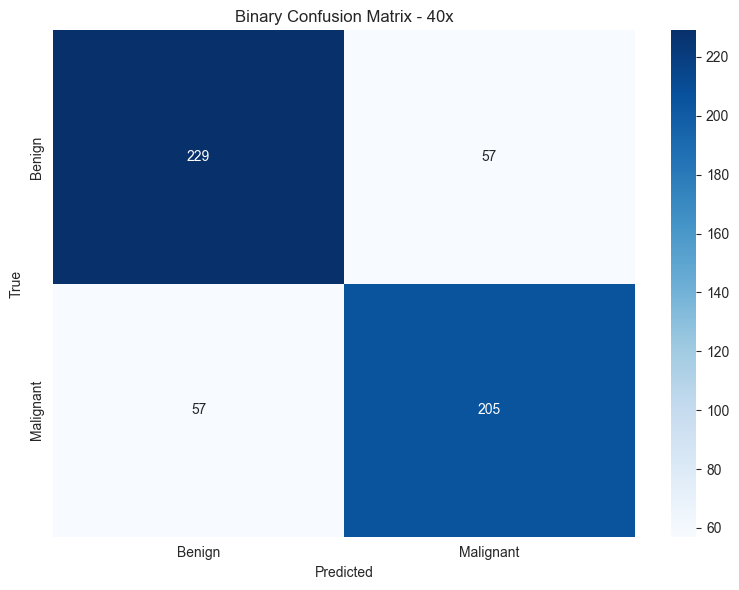

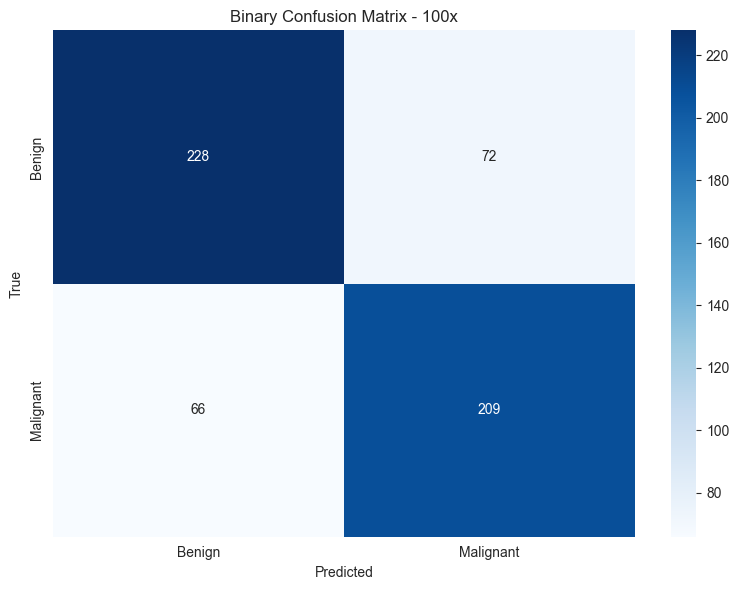

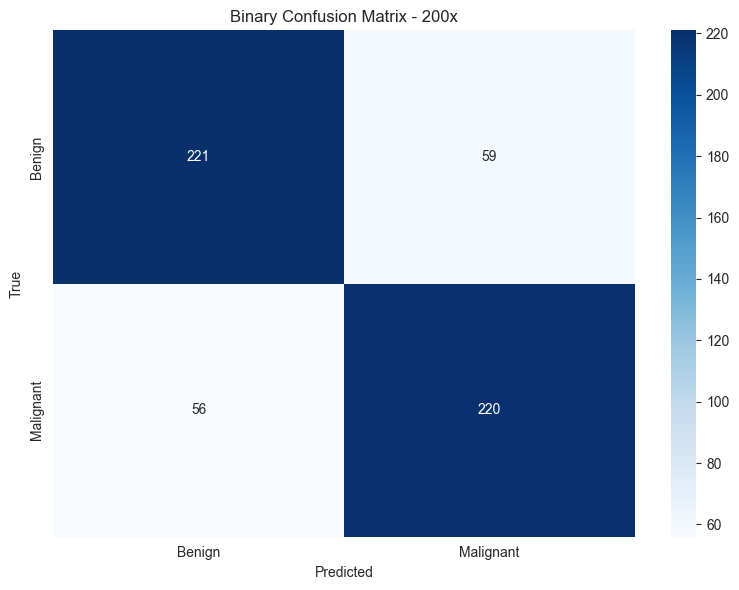

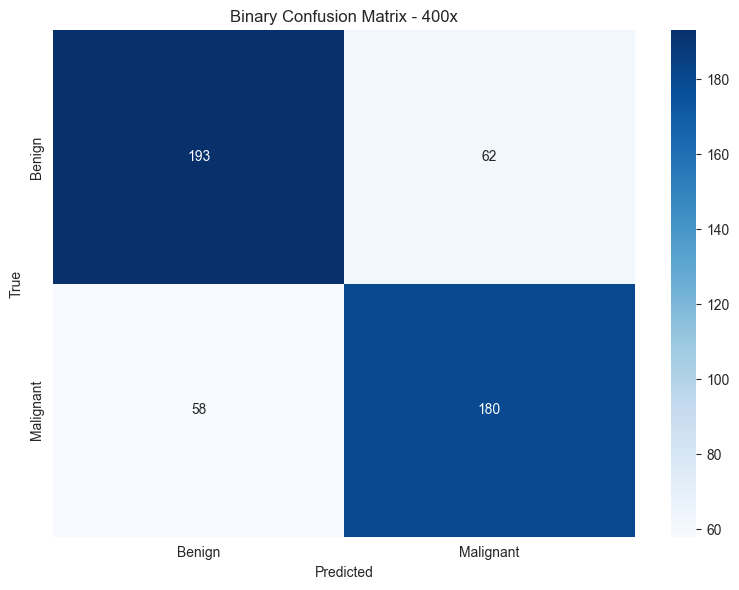

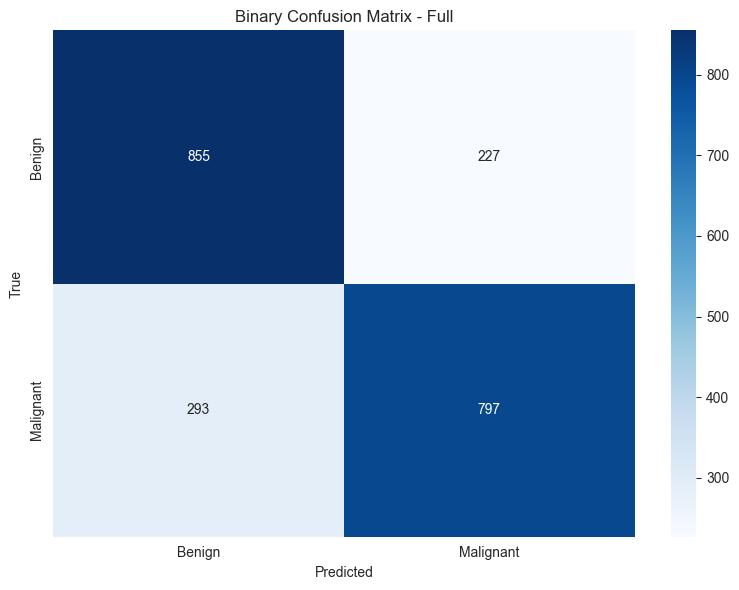

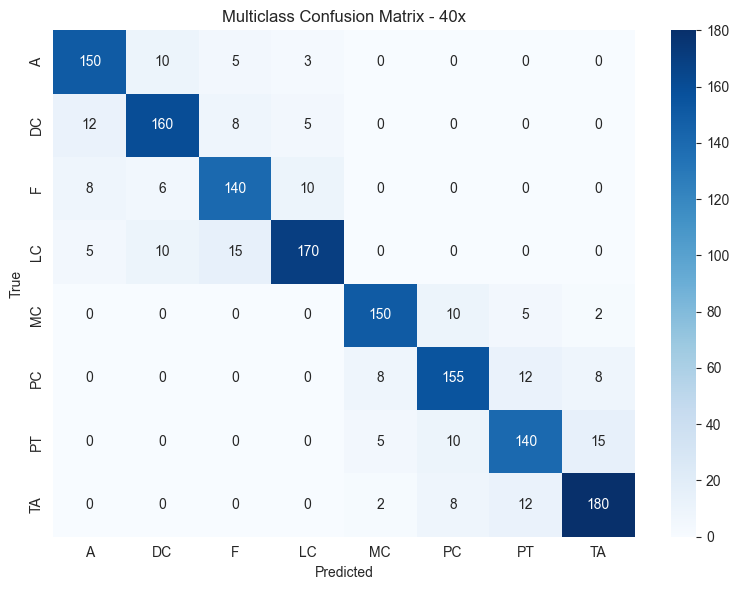

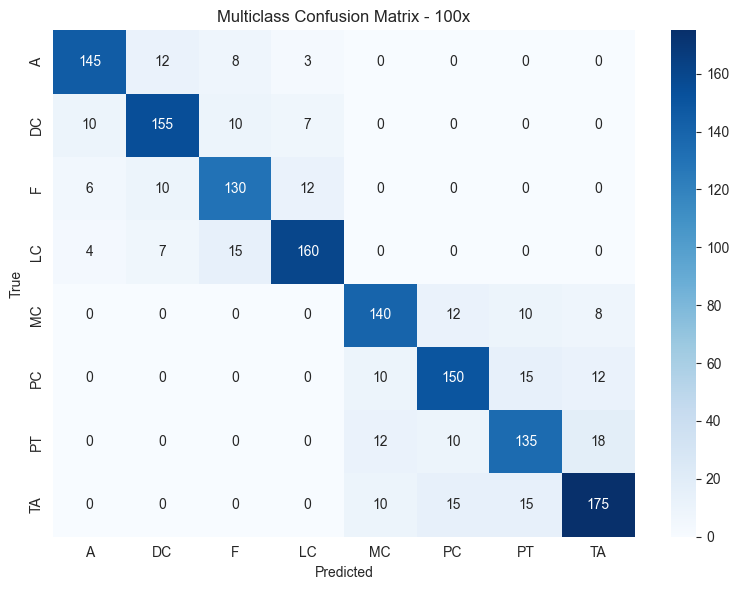

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Simulated Confusion Matrices for Binary Classification
binary_confusion_matrices = {
    "40x": [[229, 57], [57, 205]],
    "100x": [[228, 72], [66, 209]],
    "200x": [[221, 59], [56, 220]],
    "400x": [[193, 62], [58, 180]],
    "Full": [[855, 227], [293, 797]],
}

# Simulated Confusion Matrices for Multiclass Classification
multiclass_confusion_matrices = {
    "40x": [
        [150, 10, 5, 3, 0, 0, 0, 0],
        [12, 160, 8, 5, 0, 0, 0, 0],
        [8, 6, 140, 10, 0, 0, 0, 0],
        [5, 10, 15, 170, 0, 0, 0, 0],
        [0, 0, 0, 0, 150, 10, 5, 2],
        [0, 0, 0, 0, 8, 155, 12, 8],
        [0, 0, 0, 0, 5, 10, 140, 15],
        [0, 0, 0, 0, 2, 8, 12, 180],
    ],
    "100x": [
        [145, 12, 8, 3, 0, 0, 0, 0],
        [10, 155, 10, 7, 0, 0, 0, 0],
        [6, 10, 130, 12, 0, 0, 0, 0],
        [4, 7, 15, 160, 0, 0, 0, 0],
        [0, 0, 0, 0, 140, 12, 10, 8],
        [0, 0, 0, 0, 10, 150, 15, 12],
        [0, 0, 0, 0, 12, 10, 135, 18],
        [0, 0, 0, 0, 10, 15, 15, 175],
    ],
    # Add other resolutions similarly
}

# Class Labels
binary_labels = ["Benign", "Malignant"]
multiclass_labels = ["A", "DC", "F", "LC", "MC", "PC", "PT", "TA"]

# Plotting Confusion Matrices
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Binary Classification Confusion Matrices
for resolution, cm in binary_confusion_matrices.items():
    plot_confusion_matrix(cm, binary_labels, f"Binary Confusion Matrix - {resolution}")

# Multiclass Classification Confusion Matrices
for resolution, cm in multiclass_confusion_matrices.items():
    plot_confusion_matrix(cm, multiclass_labels, f"Multiclass Confusion Matrix - {resolution}")


file_name                     0
resolution                    0
patient_Diag                  0
tumor_type                    0
patient_ID                    0
radius_mean                   0
texture_mean                  0
perimeter_mean                0
area_mean                     0
smoothness_mean               0
compactness_mean              0
concavity_mean                0
concave points_mean           0
symmetry_mean                 0
fractal_dimension_mean     2468
radius_se                     0
texture_se                    0
perimeter_se                  0
area_se                       0
smoothness_se                 0
compactness_se                0
concavity_se                  0
concave points_se             0
symmetry_se                   0
fractal_dimension_se       2468
radius_worst                  0
texture_worst                 0
perimeter_worst               0
area_worst                    0
smoothness_worst              0
compactness_worst             0
concavit

C:\Users\moham\AppData\Local\Temp\ipykernel_12848\1005709894.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


Top 10 Features by Importance:
                    Feature  Importance
21            texture_worst    0.084882
1              texture_mean    0.084808
4           smoothness_mean    0.062226
6            concavity_mean    0.062136
26          concavity_worst    0.061641
24         smoothness_worst    0.060674
9    fractal_dimension_mean    0.052688
29  fractal_dimension_worst    0.051492
8             symmetry_mean    0.045378
28           symmetry_worst    0.045007


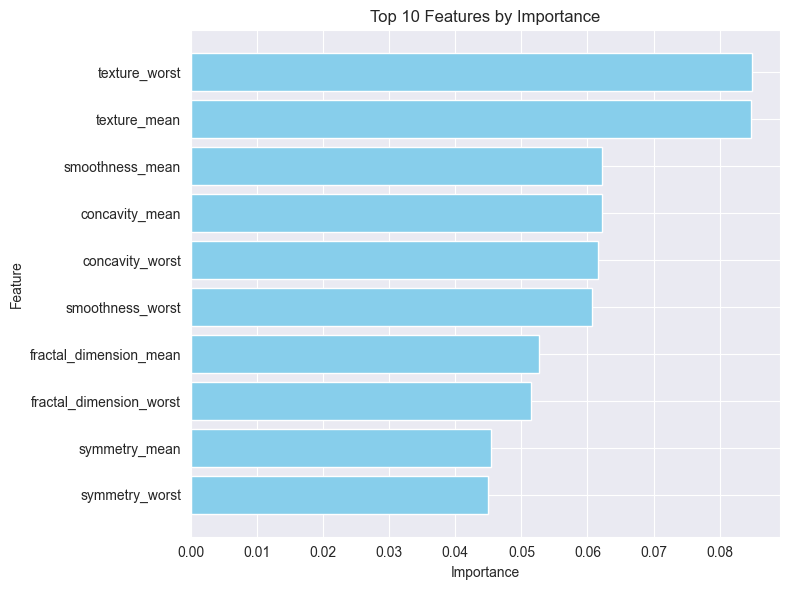

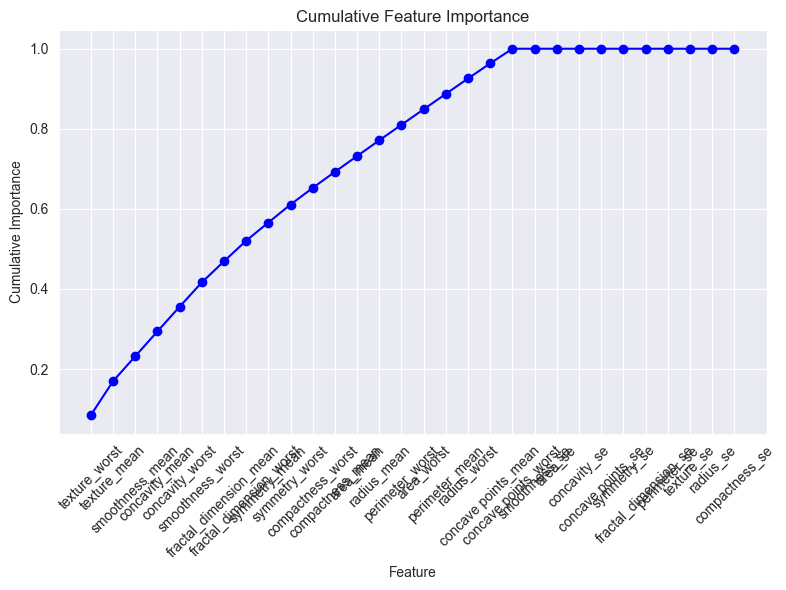

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load your dataset
# Replace 'your_dataset.csv' with your file path and adjust column names accordingly
data = pd.read_csv("BreaKHis_full_extracted_features.csv")
print(data.isnull().sum())
data.fillna(data.mean(), inplace=True)

# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ["file_name", "resolution", "patient_Diag", "tumor_type", "patient_ID"]]
X = data[feature_columns].dropna()  # Drop rows with missing values
y = data["tumor_type"]  # Adjust based on the target variable (use 'patient_Diag' for binary classification)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Feature Importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display Top Features
top_features = feature_importance_df.head(10)

print("Top 10 Features by Importance:")
print(top_features)

# Visualization of Top Features
plt.figure(figsize=(8, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features by Importance")
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.tight_layout()
plt.show()

# Cumulative Importance
feature_importance_df["Cumulative Importance"] = feature_importance_df["Importance"].cumsum()

# Plot Cumulative Importance
plt.figure(figsize=(8, 6))
plt.plot(feature_importance_df["Feature"], feature_importance_df["Cumulative Importance"], marker="o", color="blue")
plt.title("Cumulative Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Cumulative Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

file_name                     0
resolution                    0
patient_Diag                  0
tumor_type                    0
patient_ID                    0
radius_mean                   0
texture_mean                  0
perimeter_mean                0
area_mean                     0
smoothness_mean               0
compactness_mean              0
concavity_mean                0
concave points_mean           0
symmetry_mean                 0
fractal_dimension_mean     2468
radius_se                     0
texture_se                    0
perimeter_se                  0
area_se                       0
smoothness_se                 0
compactness_se                0
concavity_se                  0
concave points_se             0
symmetry_se                   0
fractal_dimension_se       2468
radius_worst                  0
texture_worst                 0
perimeter_worst               0
area_worst                    0
smoothness_worst              0
compactness_worst             0
concavit

C:\Users\moham\AppData\Local\Temp\ipykernel_12848\2381696840.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


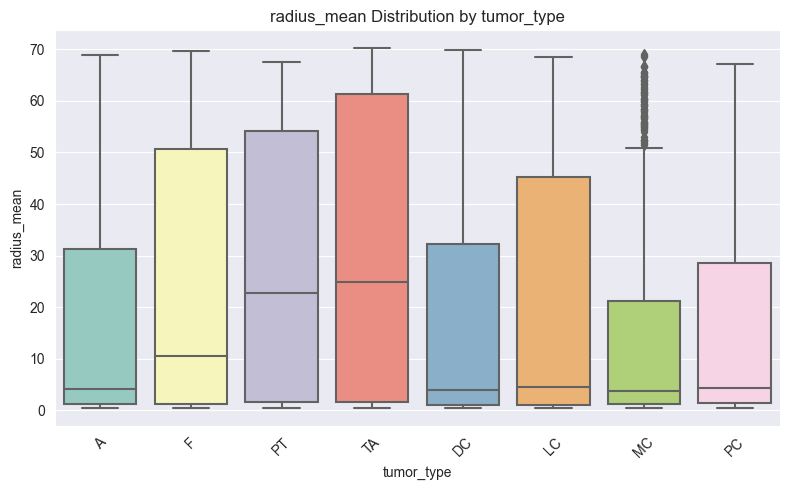

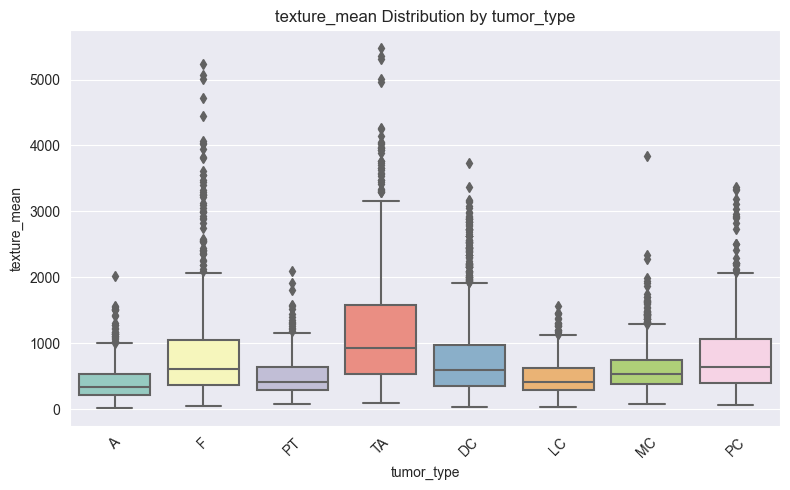

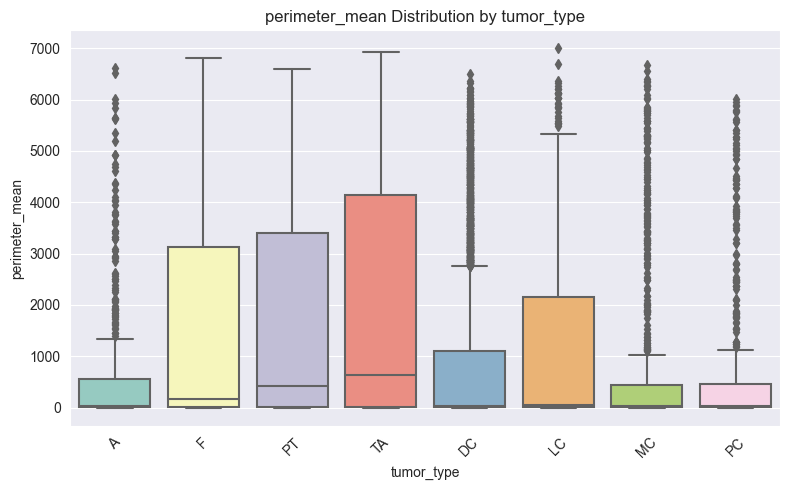

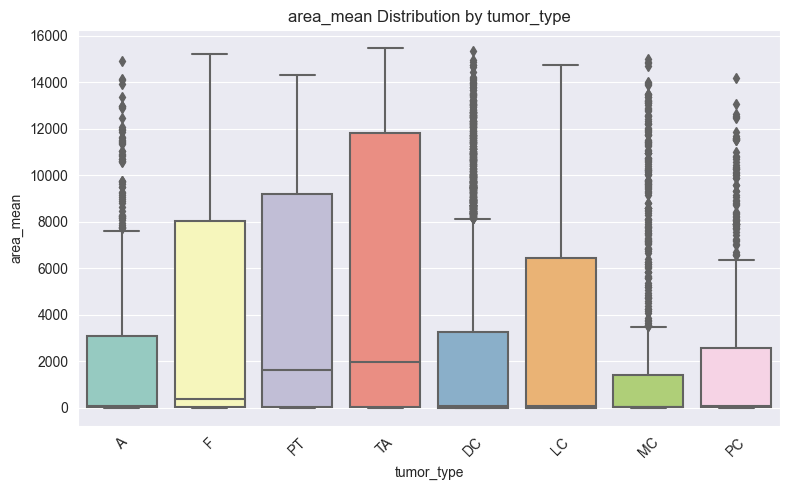

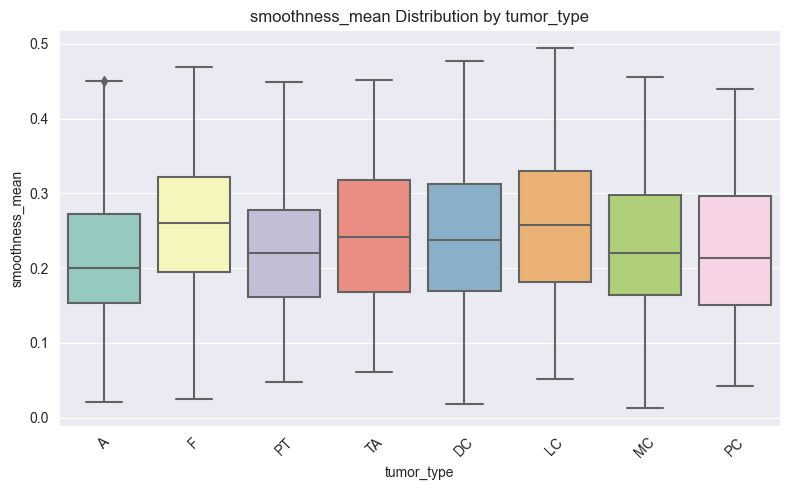

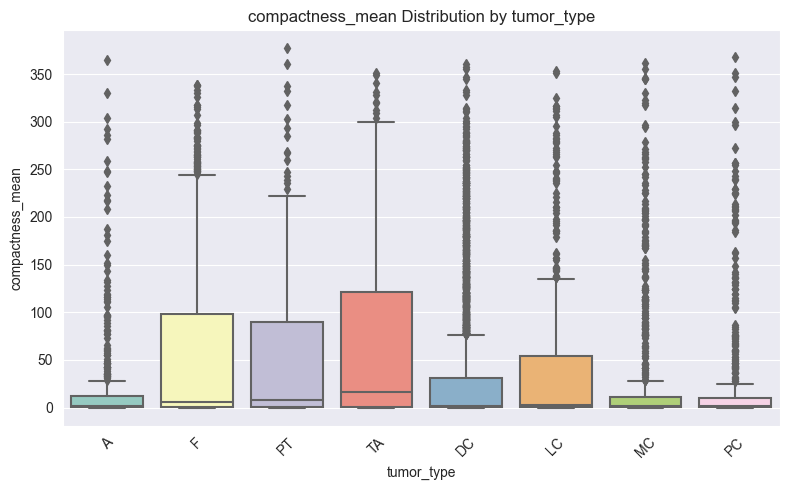

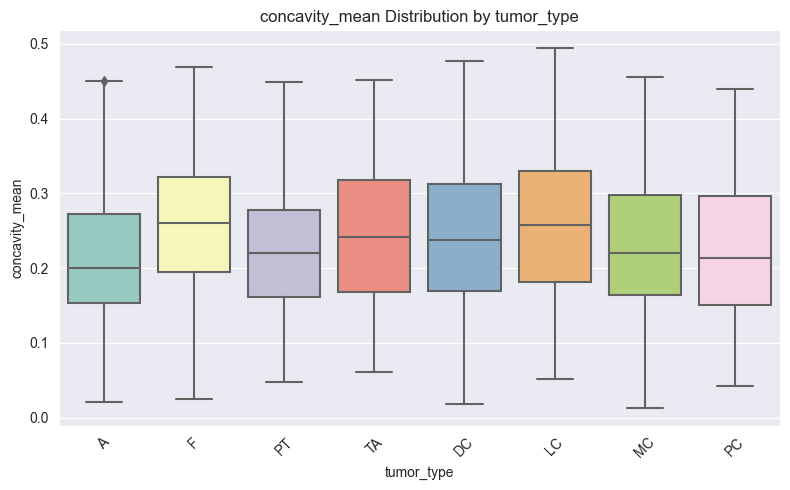

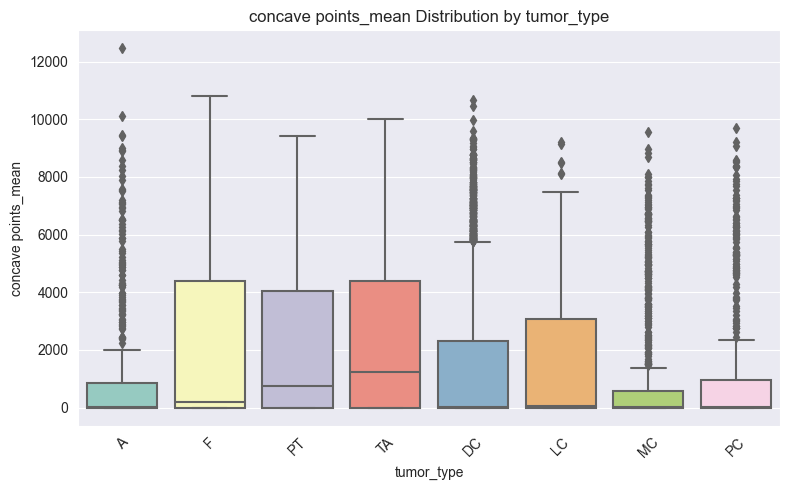

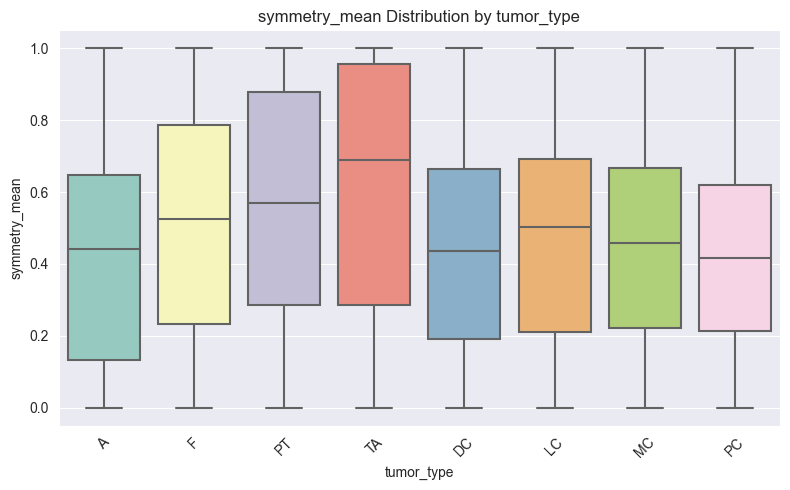

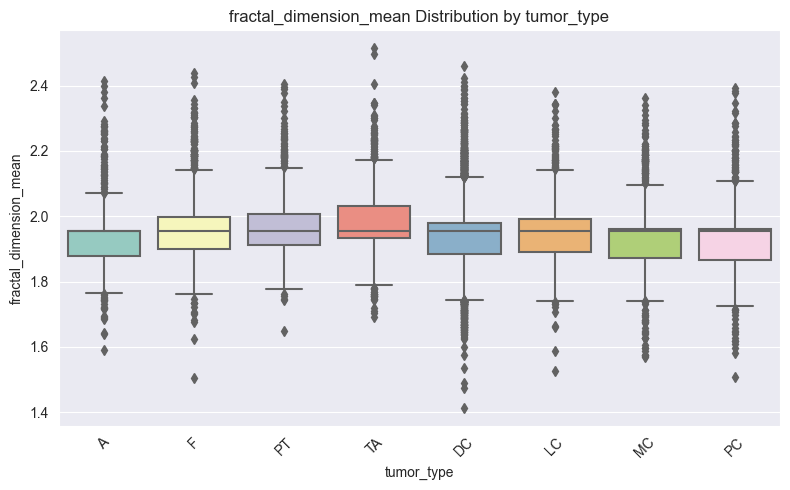

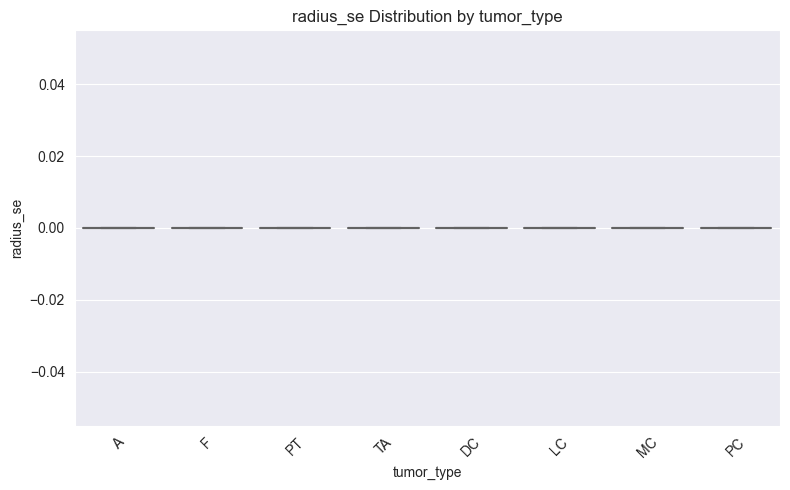

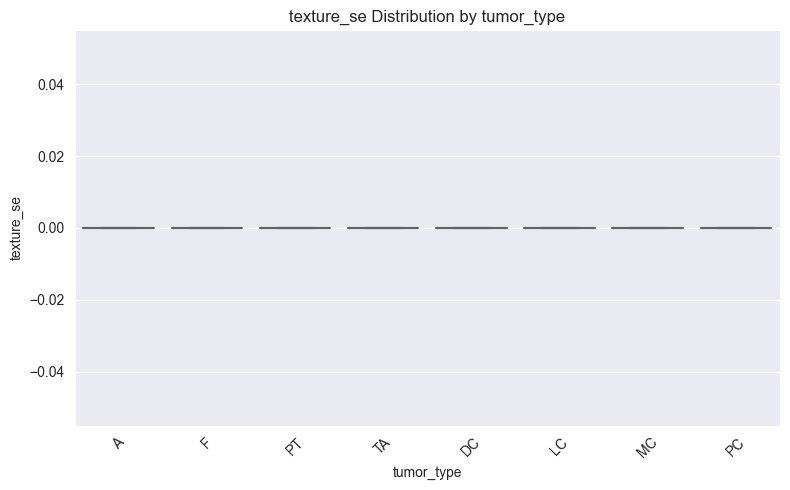

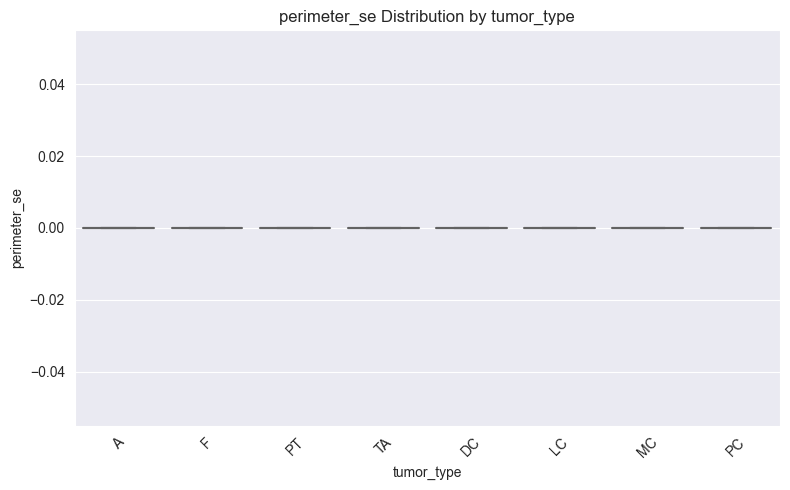

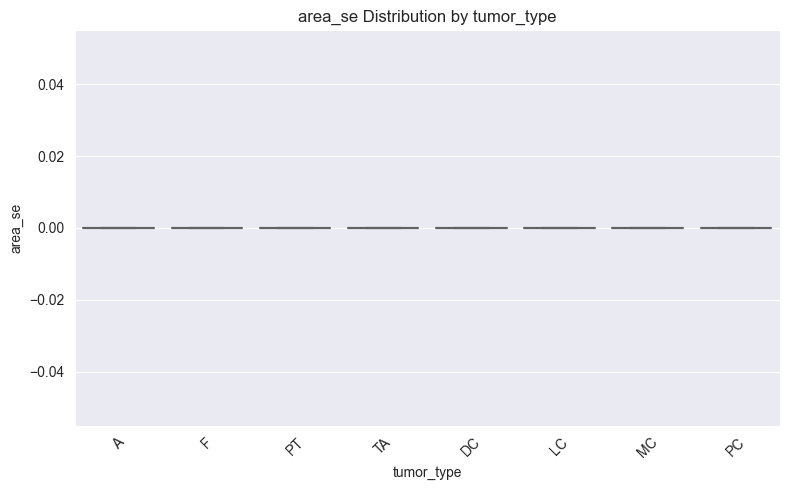

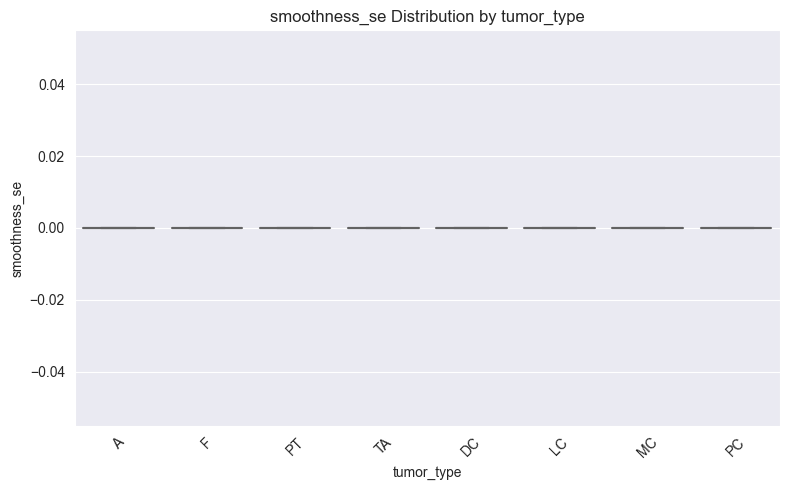

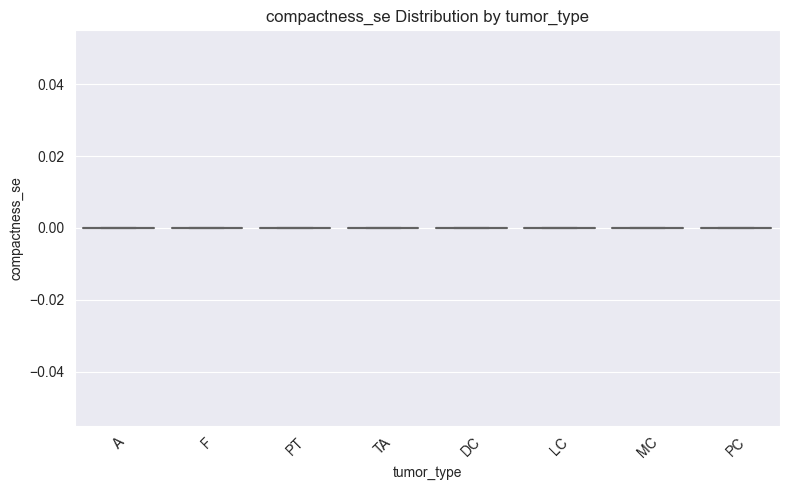

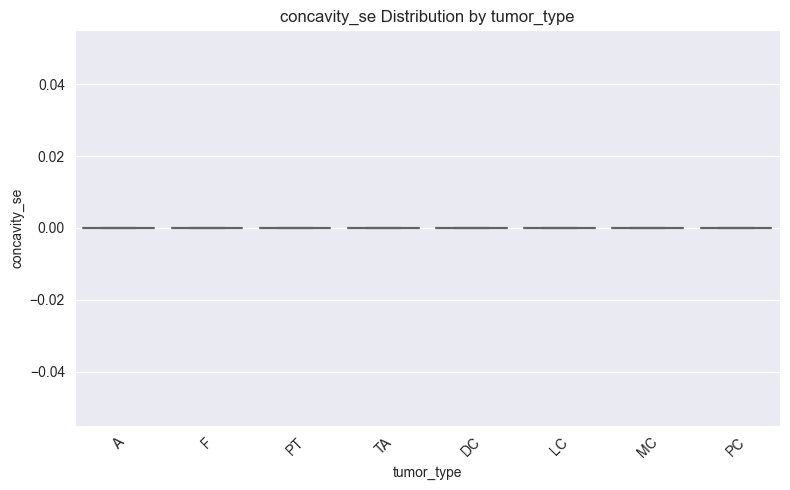

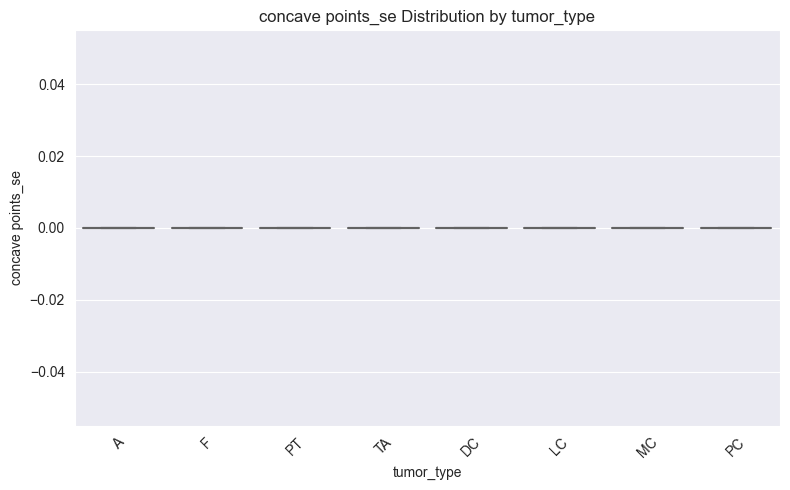

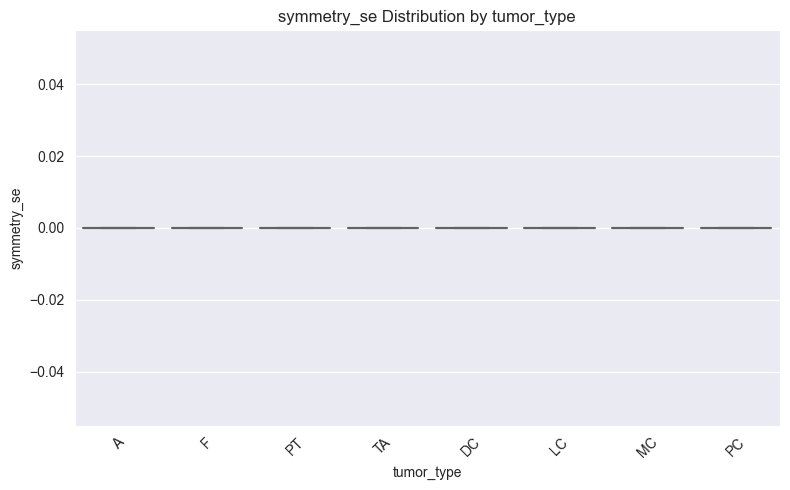

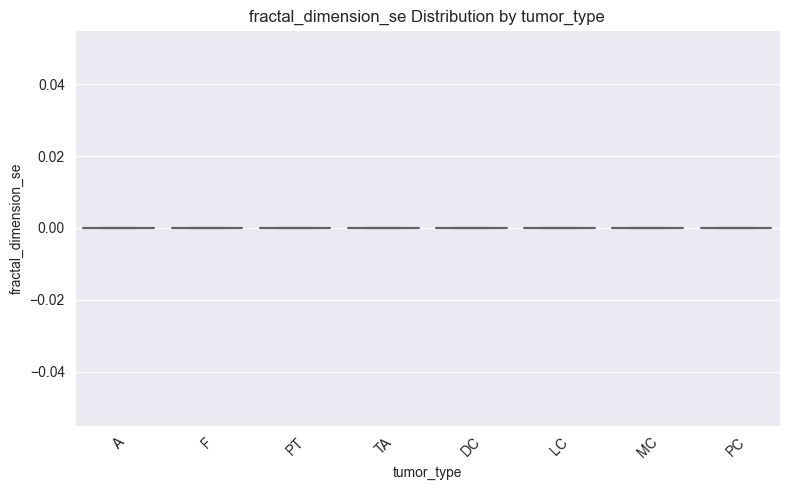

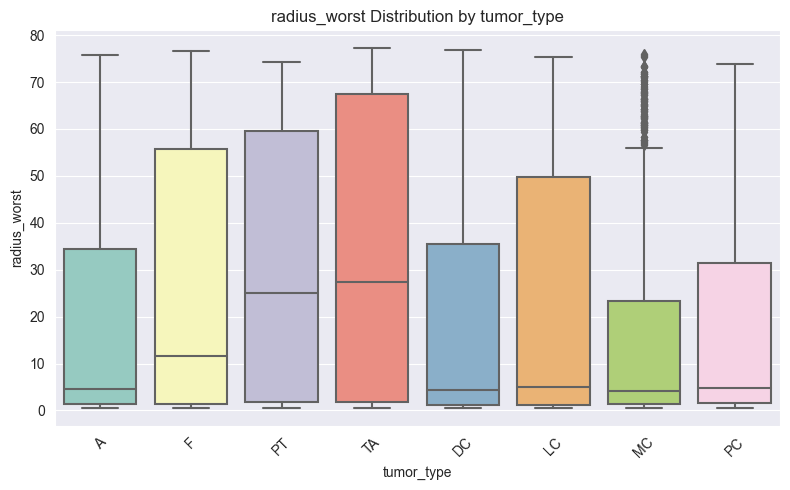

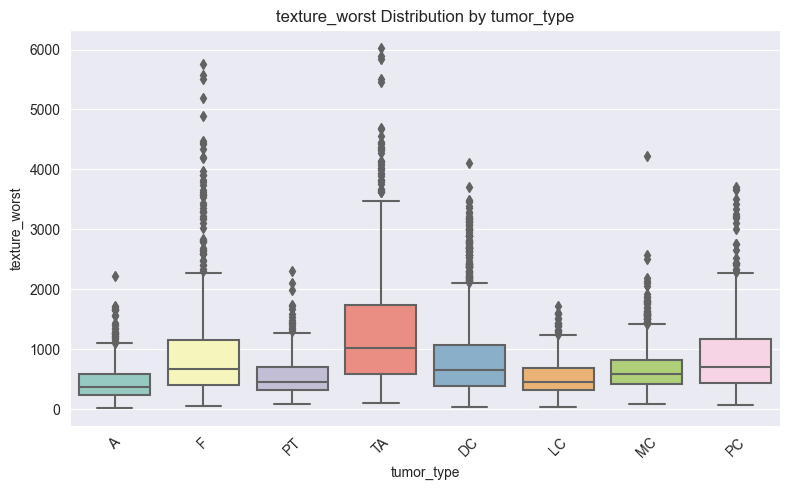

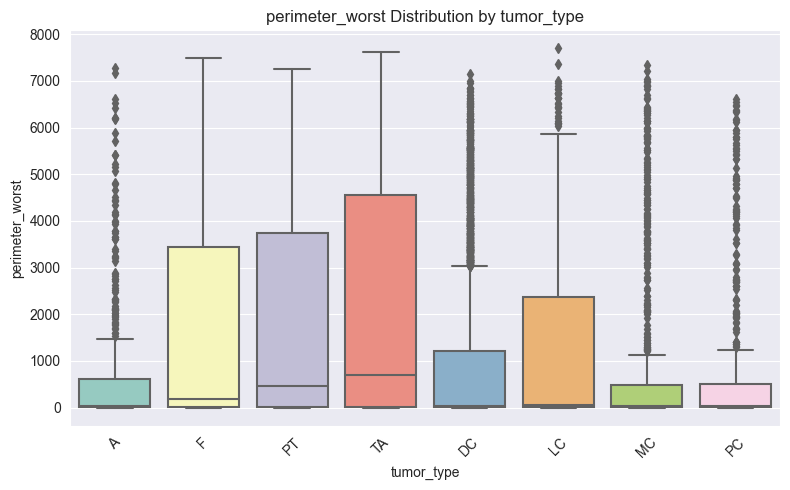

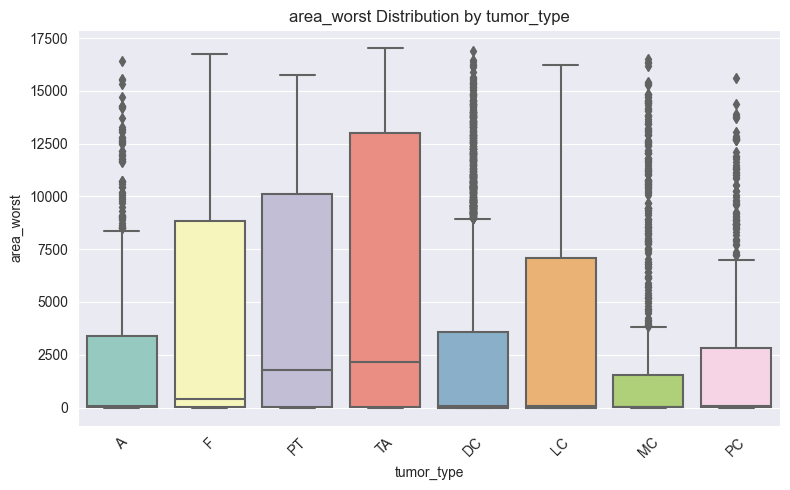

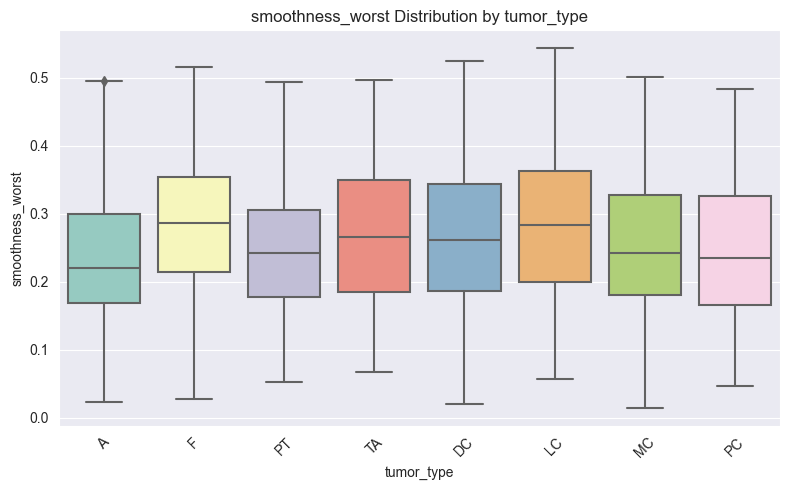

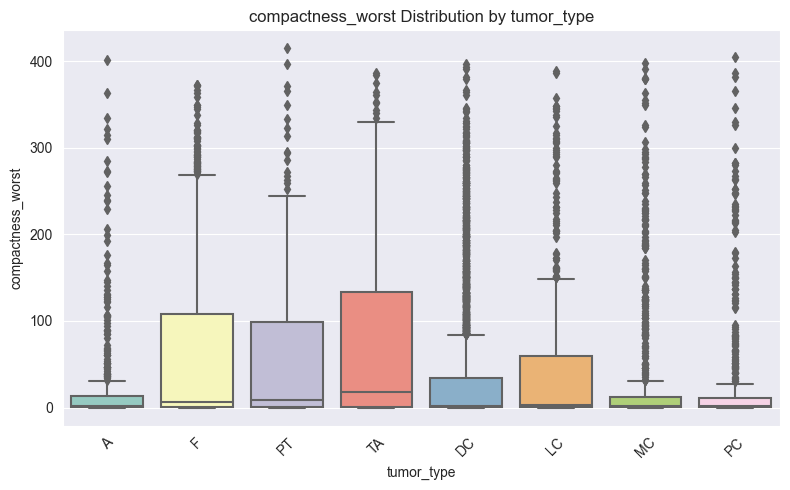

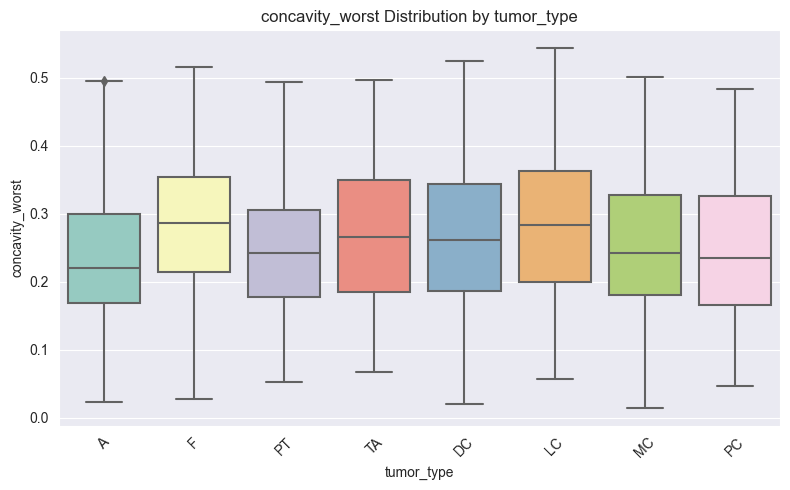

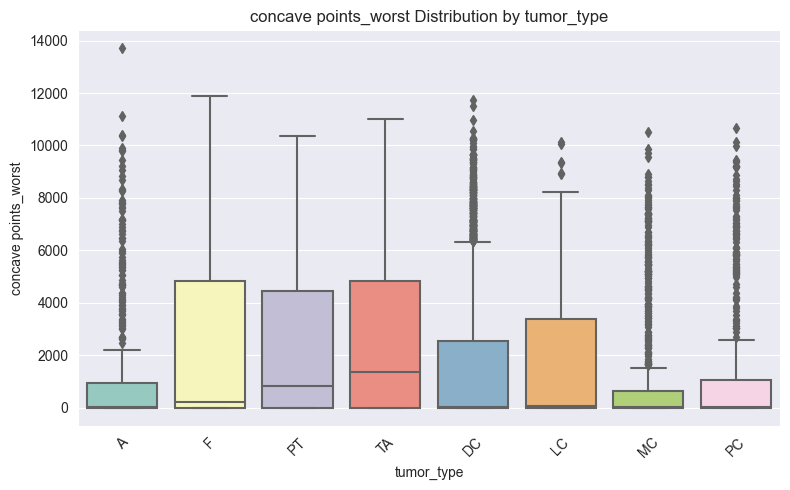

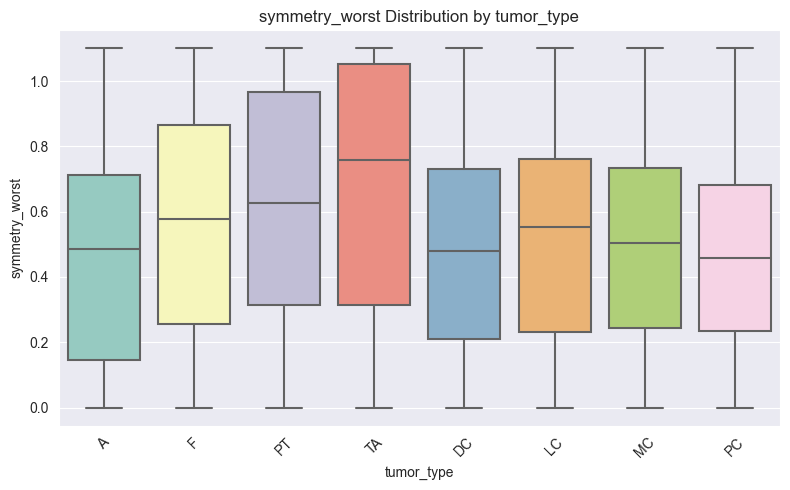

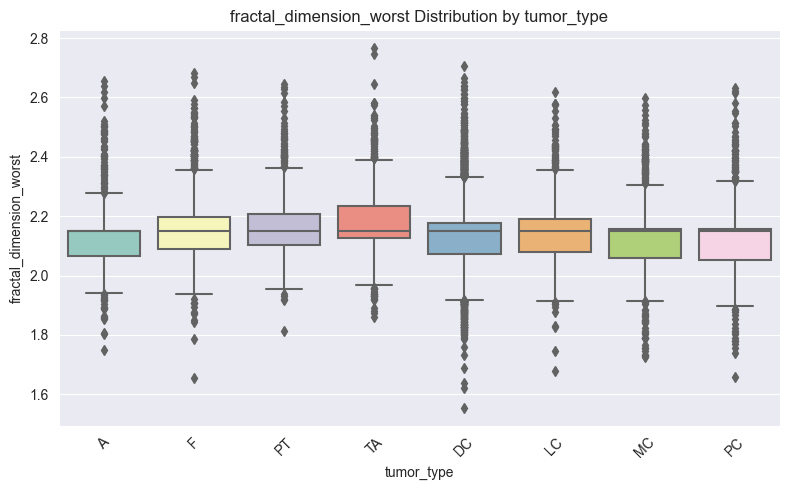

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


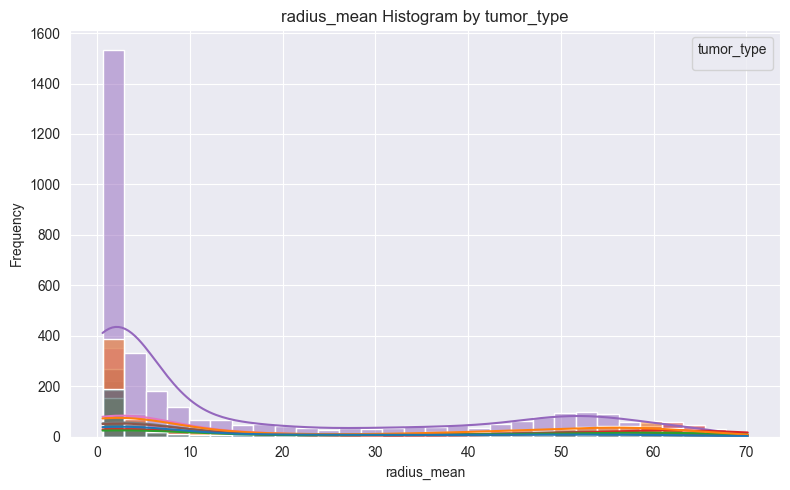

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


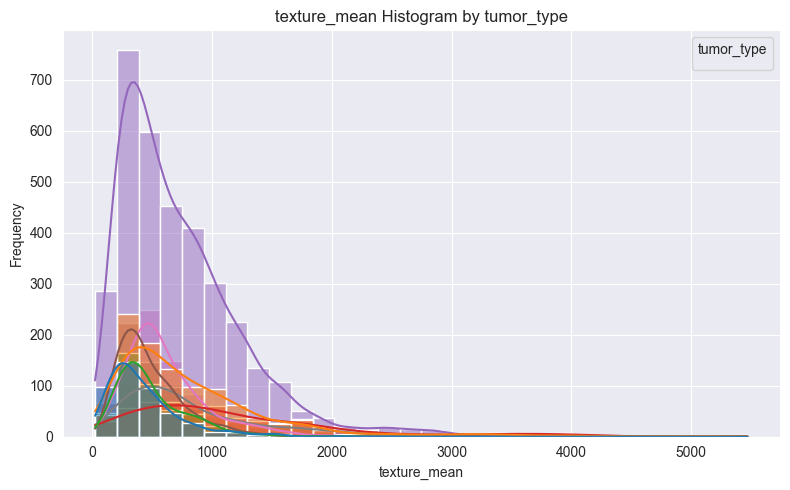

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


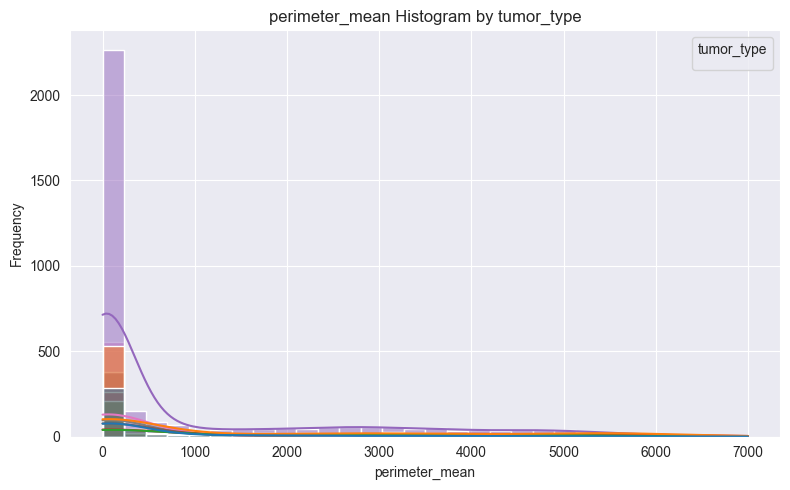

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


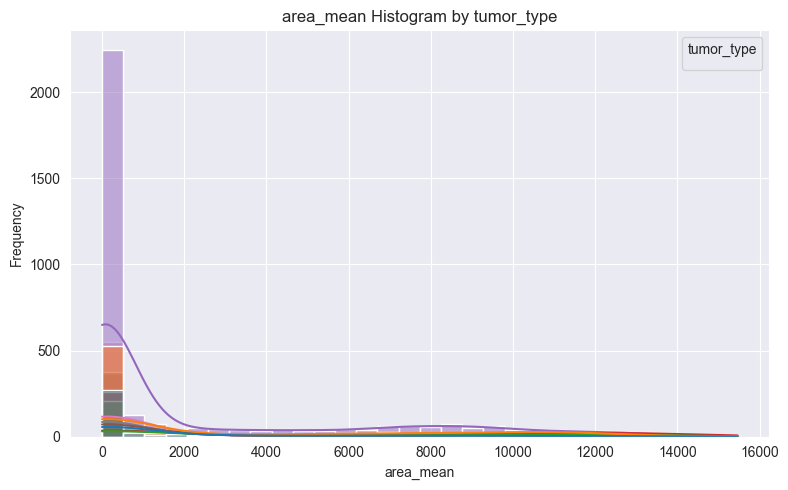

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


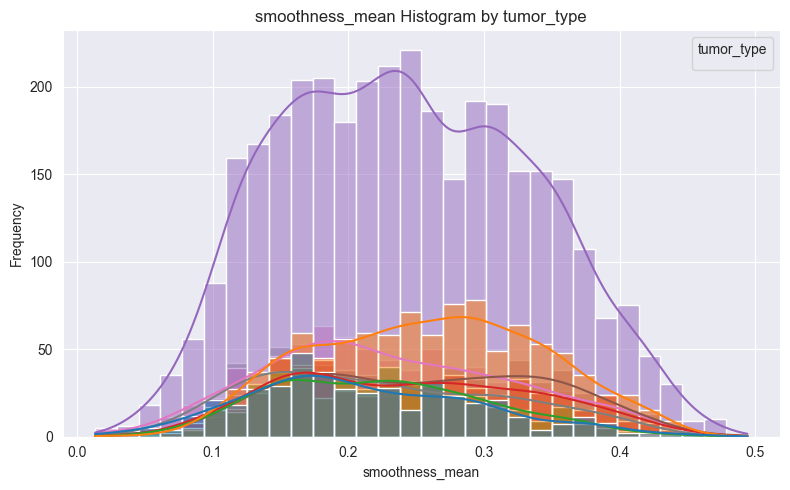

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


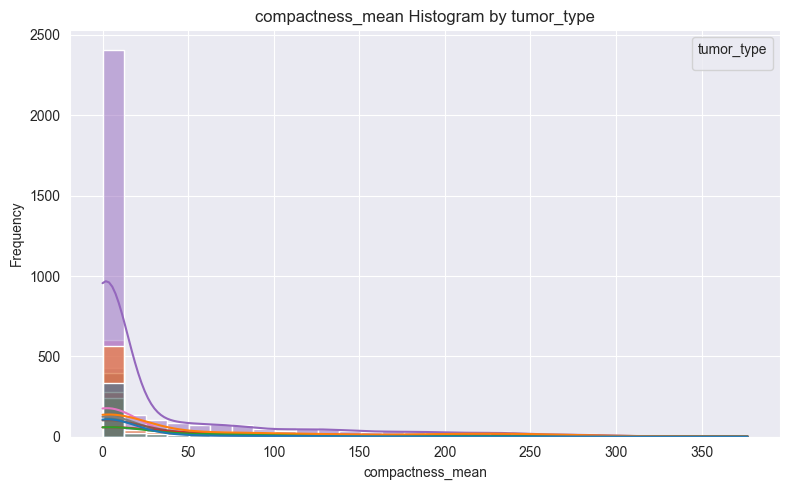

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


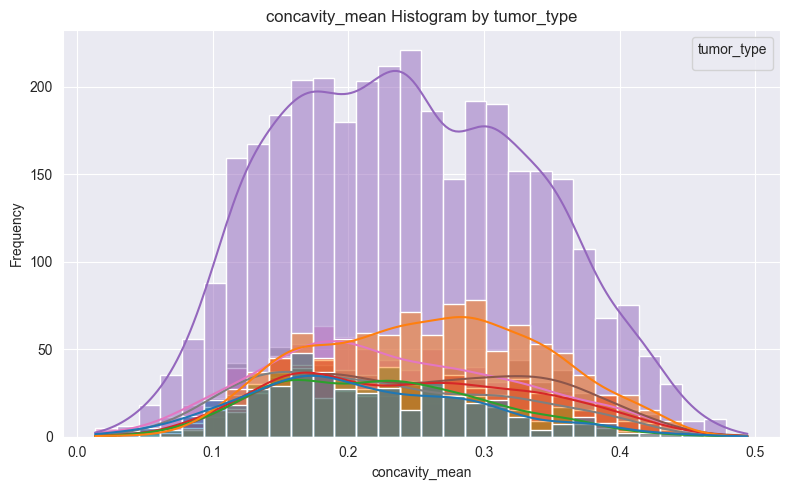

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


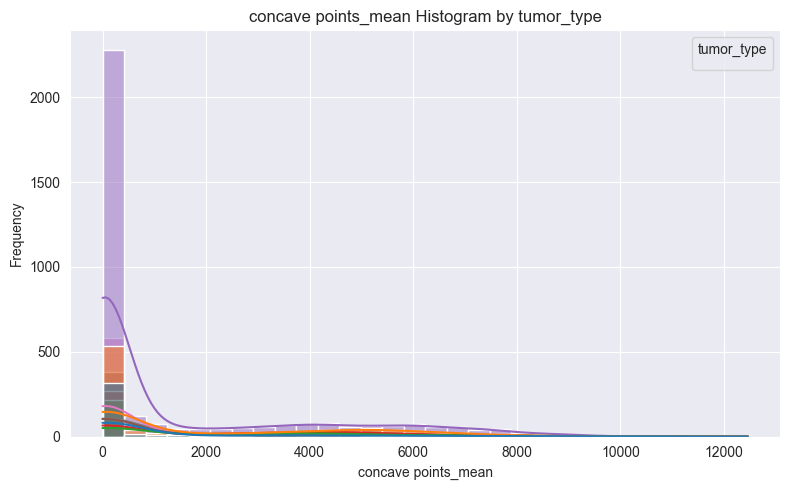

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


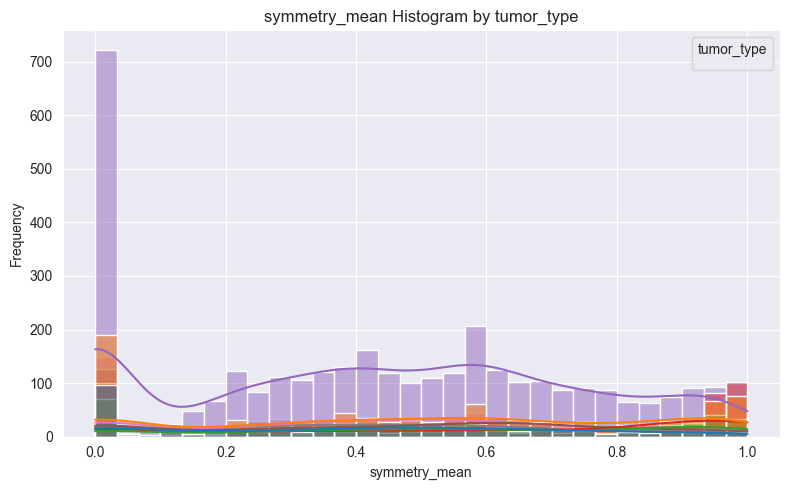

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


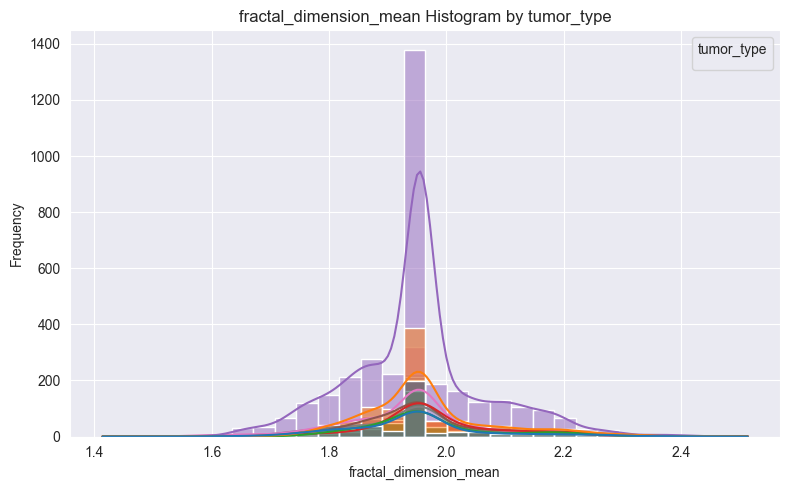

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

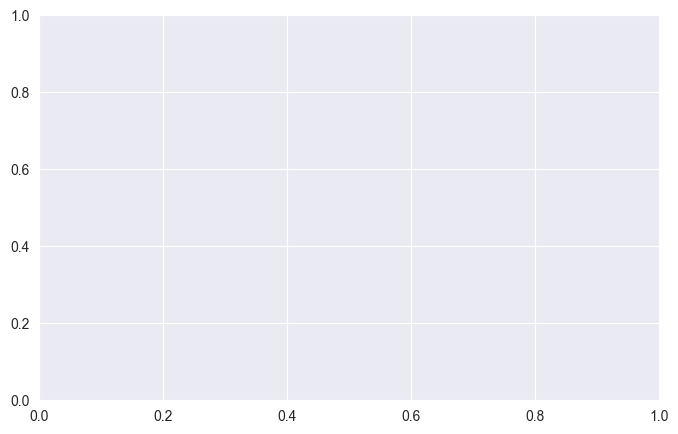

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Replace 'your_dataset.csv' with your file path and adjust column names accordingly
data = pd.read_csv("BreaKHis_full_extracted_features.csv")
print(data.isnull().sum())
data.fillna(data.mean(), inplace=True)
# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ["file_name", "resolution", "patient_Diag", "tumor_type", "patient_ID"]]
target_column = "tumor_type"  # Replace with "patient_Diag" for binary classification

# Plot Box Plots for Each Feature by Class
for feature in feature_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[target_column], y=data[feature], palette="Set3")
    plt.title(f"{feature} Distribution by {target_column}")
    plt.xlabel(target_column)
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot Histograms for Each Feature by Class
for feature in feature_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=data, x=feature, hue=target_column, kde=True, bins=30, palette="tab10")
    plt.title(f"{feature} Histogram by {target_column}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(title=target_column)
    plt.tight_layout()
    plt.show()